In [2]:
import subprocess
import os
from LAMMPS_gen_in_file import * 
from LAMMPS_data_preprocess import * 
from LAMMPS_analysis import *

velocities = [0.1, 0.5, 1, 1.5]
temperature = 300

test_num = 1

            
for velocity in velocities:
    dump_dir = "./runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    dump_dir_ = "runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    
    try:
        os.mkdir("./runs")
    except FileExistsError:
        print('Folder already exist.')
        
    try:
        os.mkdir("./runs/test_" + str(1))
    except FileExistsError:
        print('Folder already exist.')
        
    
    generate_in_file(velocity, temperature, dump_dir=dump_dir, output_file = dump_dir_ + "/in.perforation", 
                     iterations = [1000, 1000, 0, 10000], ts = [0.1, 0.1, 0.05])
    
    #os.system('cp ffield_reax.cho2016 ' + dump_dir_ + '/ffield_reax.cho2016')
    os.system('cp C60.data ' + dump_dir_ + '/C60.data')
    
    prepare_data(graphene_size=[40, 40], input_c60_file = dump_dir_ + '/C60.data', 
                 output_c60_centered = dump_dir_ + '/centered_C60.data', 
                 output_graphene_centered = dump_dir_ + '/centered_graphene.data', 
                 output_file= dump_dir_ + '/combined.data', 
                 output_graphene = dump_dir_ + '/graphene.data', 
                 z_graphene = 20, z_c60 = 5)

    lammps_path = "/home/korotnev/Documents/LAMMPS/lammps-29Aug2024/src/lmp_serial"  

    script_path = dump_dir_ + '/in.perforation'

    try:
        result = subprocess.run([lammps_path, '-in', script_path], check=True, 
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print("LAMMPS simulation started successfully!")
        print(result.stdout.decode())  # Вывод успешных сообщений
        print(result.stderr.decode())  # Вывод сообщений об ошибках
        
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while running LAMMPS: {e}")

Folder already exist.
Folder already exist.
Folders already exist
In File generated.

Preparing data started.

Graphene structure with 1080 atoms has been written to runs/test_1/vel_0.1_temp_300/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared


KeyboardInterrupt: 

In [7]:
def run_lammps_simulation(velocity, temperature):
    dump_dir = "./runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    dump_dir_ = "runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    
    temp_ts = 0.05 * 0.02 / velocity
    
    try:
        os.mkdir("./runs")
    except FileExistsError:
        print('Folder already exist.')
        
    try:
        os.mkdir("./runs/test_" + str(1))
    except FileExistsError:
        print('Folder already exist.')

    generate_in_file(velocity, temperature, dump_dir=dump_dir, output_file=dump_dir_ + "/in.perforation", 
                     iterations=[1000, 1000, 0, 10000], ts = [0.1, 0.1, temp_ts])
    
    os.system(f'cp C60.data {dump_dir_}/C60.data')
    
    prepare_data(graphene_size=[20, 20], input_c60_file=f'{dump_dir_}/C60.data', 
                 output_c60_centered=f'{dump_dir_}/centered_C60.data', 
                 output_graphene_centered=f'{dump_dir_}/centered_graphene.data', 
                 output_file=f'{dump_dir_}/combined.data', 
                 output_graphene=f'{dump_dir_}/graphene.data', 
                 z_graphene=20, z_c60=5)

    lammps_path = "/home/korotnev/Documents/LAMMPS/lammps-29Aug2024/src/lmp_serial"  
    script_path = f'{dump_dir_}/in.perforation'

    try:
        result = subprocess.run([lammps_path, '-in', script_path], check=True, 
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        print(f"LAMMPS simulation for velocity {velocity} started successfully!")
        #print(result.stdout.decode())  
        #print(result.stderr.decode())  
    except subprocess.CalledProcessError as e:
        print(f"Error occurred while running LAMMPS for velocity {velocity}: {e}")
        
    df_graphene = get_dataset(get_files(dump_dir_, el='gr'))
    df_c60 = get_dataset(get_files(dump_dir_, el='c60'))
    
    get_plots_coords_velocities(df_graphene, name=dump_dir_ + '/graphene')
    get_plots_coords_velocities(df_c60, name=dump_dir_ + '/c60')
    
    print(f'Фуллерен при Температуре {temperature}, скорости {velocity} : сломан : {is_broken(df_c60, alpha = 0.03)}')
    print(f'Графен при Температуре {temperature}, скорости {velocity} : сломан : {is_broken(df_graphene, alpha = 0.03)}')
    
    return is_broken(df_graphene, alpha = 0.1)

In [8]:
def find_velocity(v_min, v_max, temp, tol = 0.1):
    print(f"Starting new velocity search with params\n temp {temp} \n v_min {v_min} \n v_max {v_max} \n")
    if 2 * (v_max - v_min) / (v_max + v_min) < tol:
        print(f"Solution has found, temp {temp}, velocity {(v_max + v_min) / 2}\n")
        return (v_max + v_min) / 2
    
    bool_ = run_lammps_simulation((v_max + v_min) / 2, temp)
    
    if bool_:
        return find_velocity(v_min, (v_max + v_min) / 2, temp, tol=tol)
    else:
        return find_velocity((v_max + v_min) / 2, v_max, temp, tol=tol)
    
def start_search(v_min, v_max, temp, tol = 0.1):
    b_min = run_lammps_simulation(v_min, temp)
    b_max = run_lammps_simulation(v_max, temp)
    
    if (b_min and b_max) or (not b_min and not b_max):
        return 0
    return find_velocity(v_min, v_max, temp, tol=tol)

Folder already exist.Folder already exist.Folder already exist.Folder already exist.Folder already exist.



In File generated.

Folder already exist.Folder already exist.Folder already exist.



Folder already exist.In File generated.
In File generated.
In File generated.

Preparing data started.




In File generated.
Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_0.01_temp_275/graphene.data.Preparing data started.
Preparing data started.




Graphene has generated. Centering data started.
Preparing data started.


Graphene structure with 270 atoms has been written to runs/test_1/vel_0.01_temp_250/graphene.data.Graphene structure with 270 atoms has been written to runs/test_1/vel_0.01_temp_350/graphene.data.Graphene structure with 270 atoms has been written to runs/test_1/vel_0.01_temp_300/graphene.data.


Graphene has generated. Centering data started.
Graphene structure with 270 atoms has been written to runs/test_1/vel_0.01_temp_325/

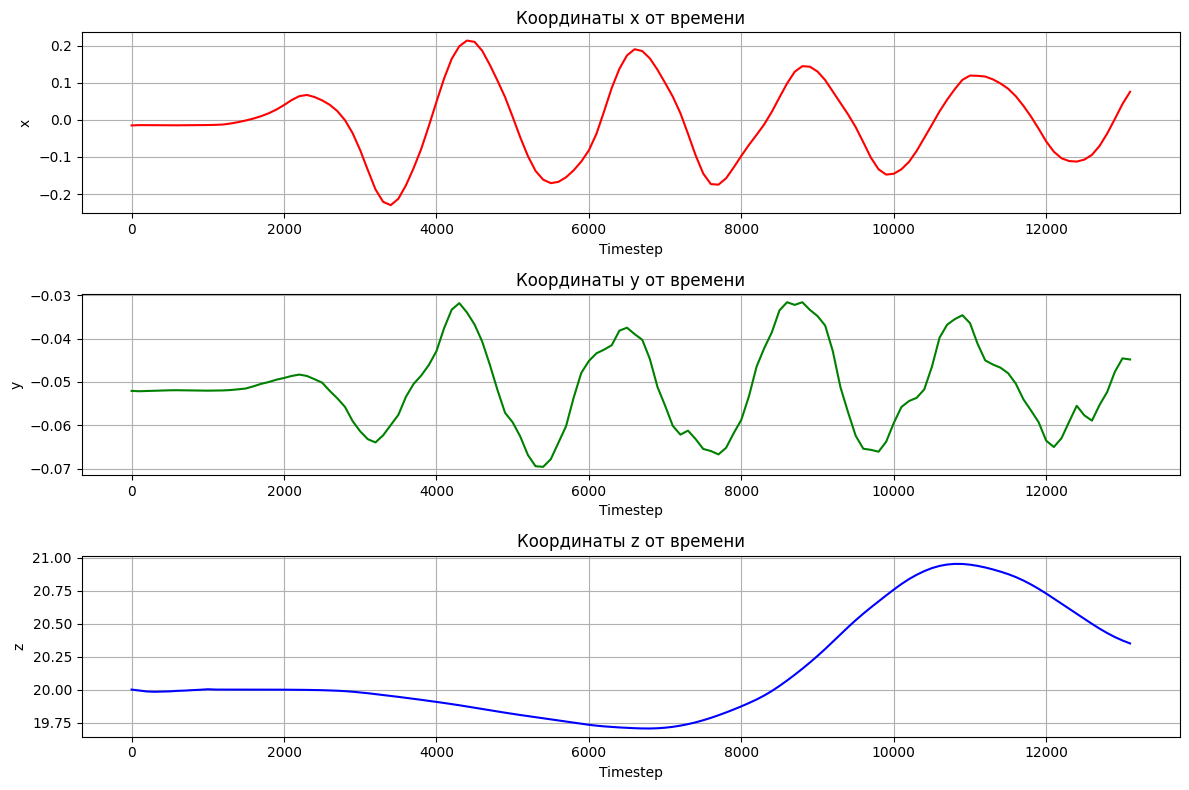

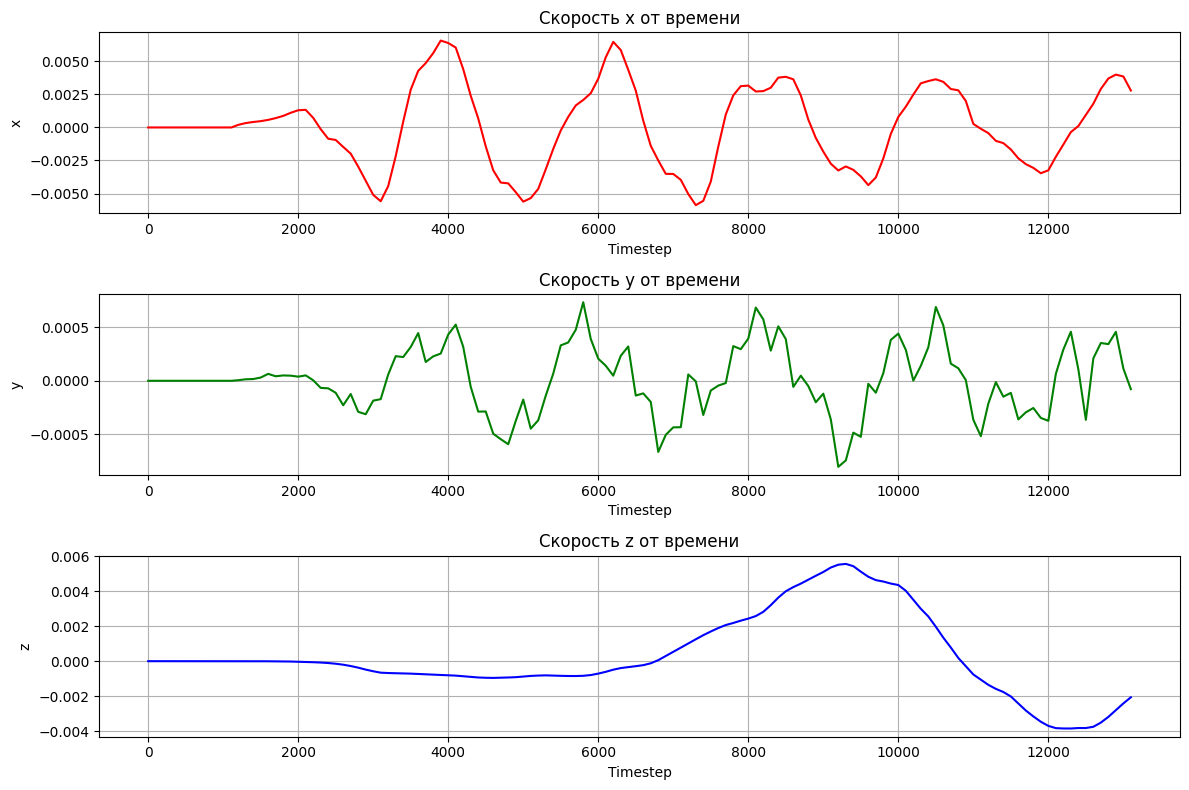

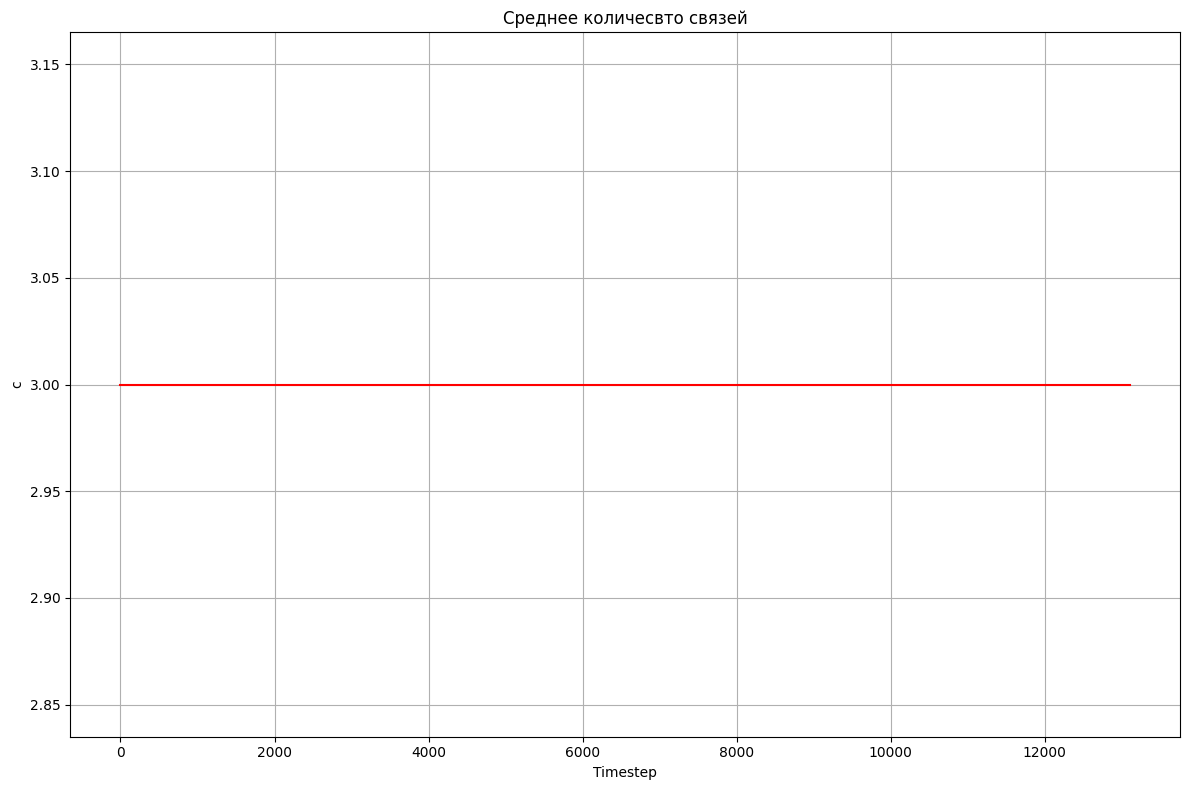

LAMMPS simulation for velocity 0.01 started successfully!


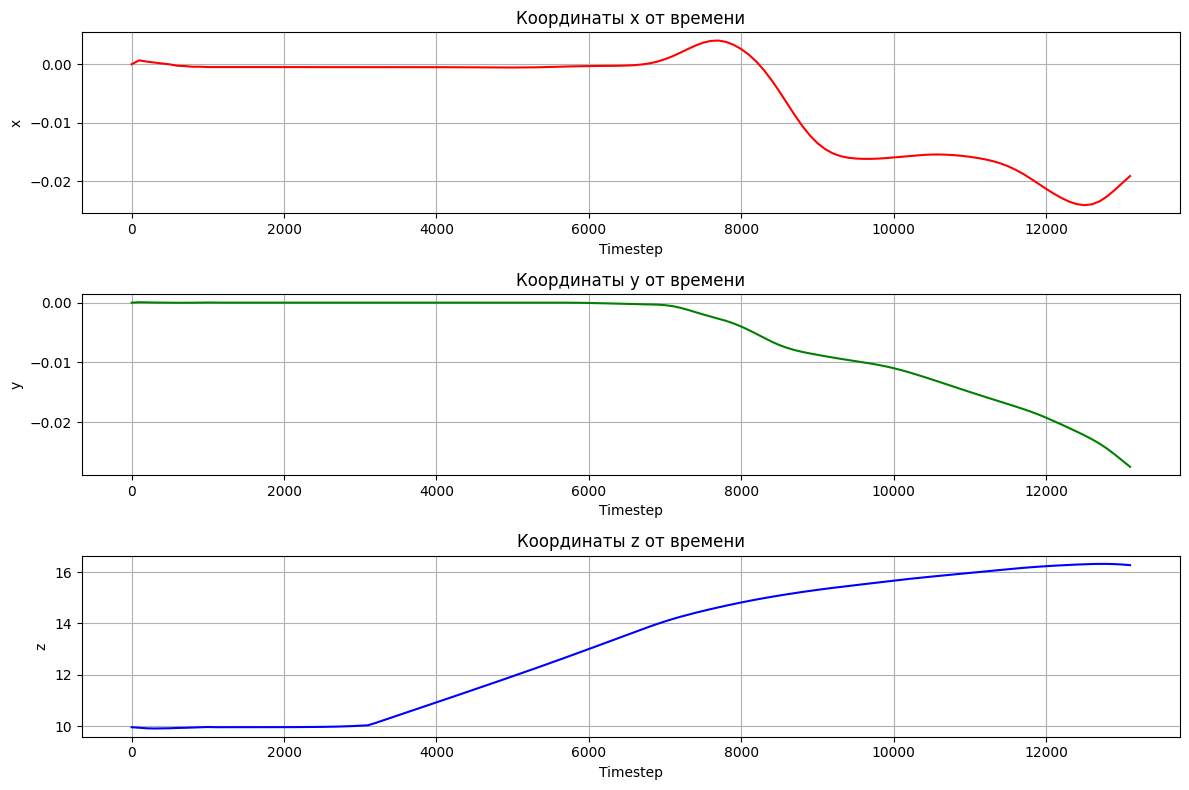

LAMMPS simulation for velocity 0.01 started successfully!


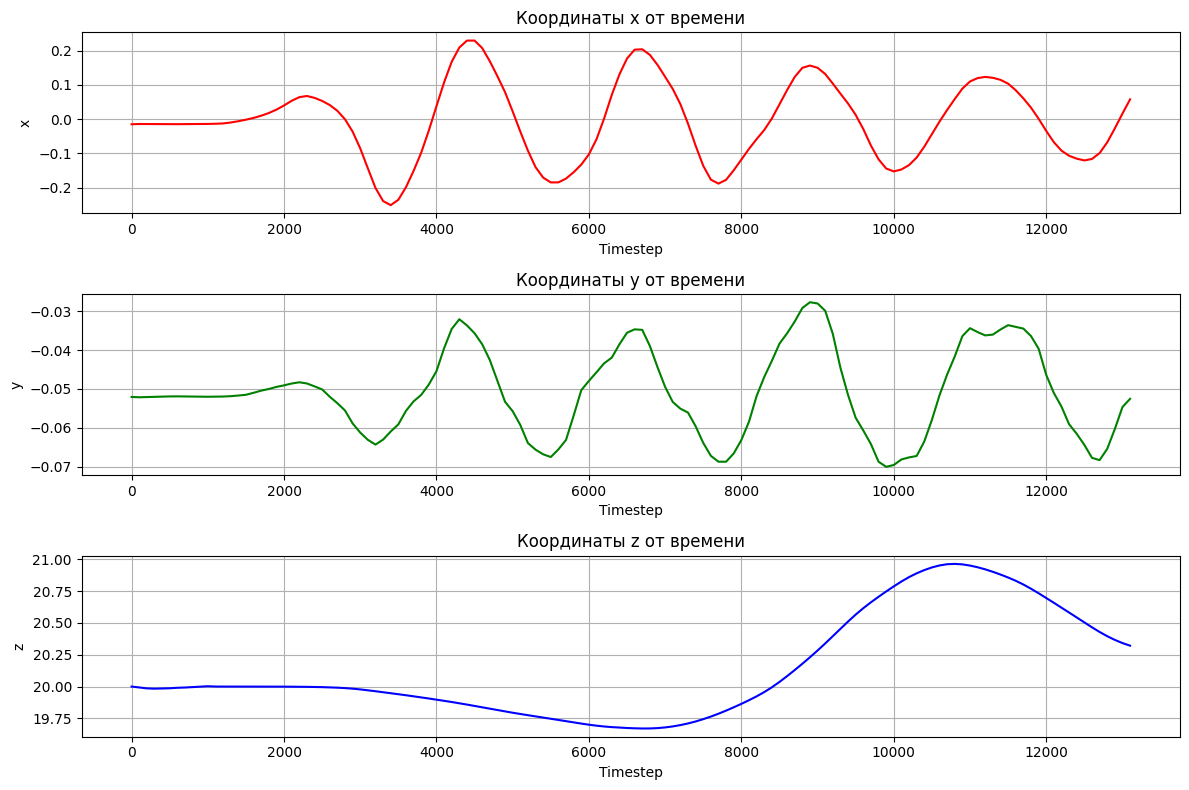

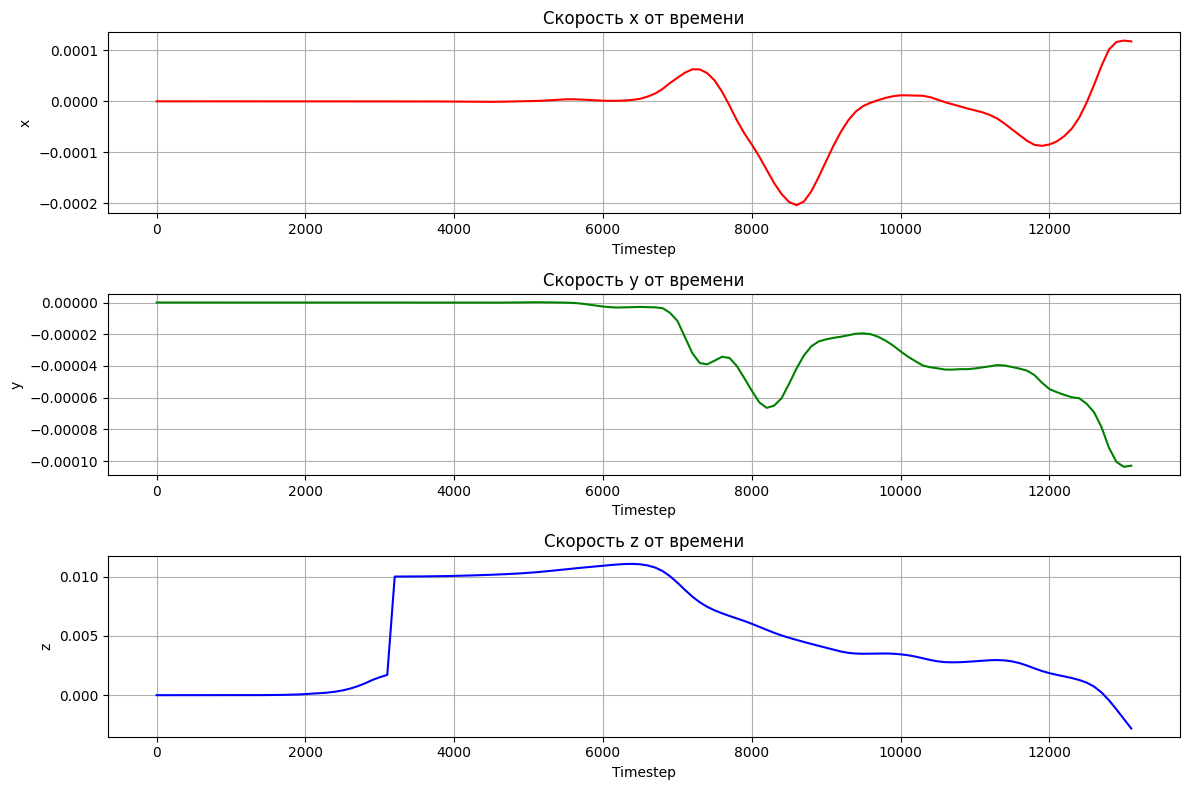

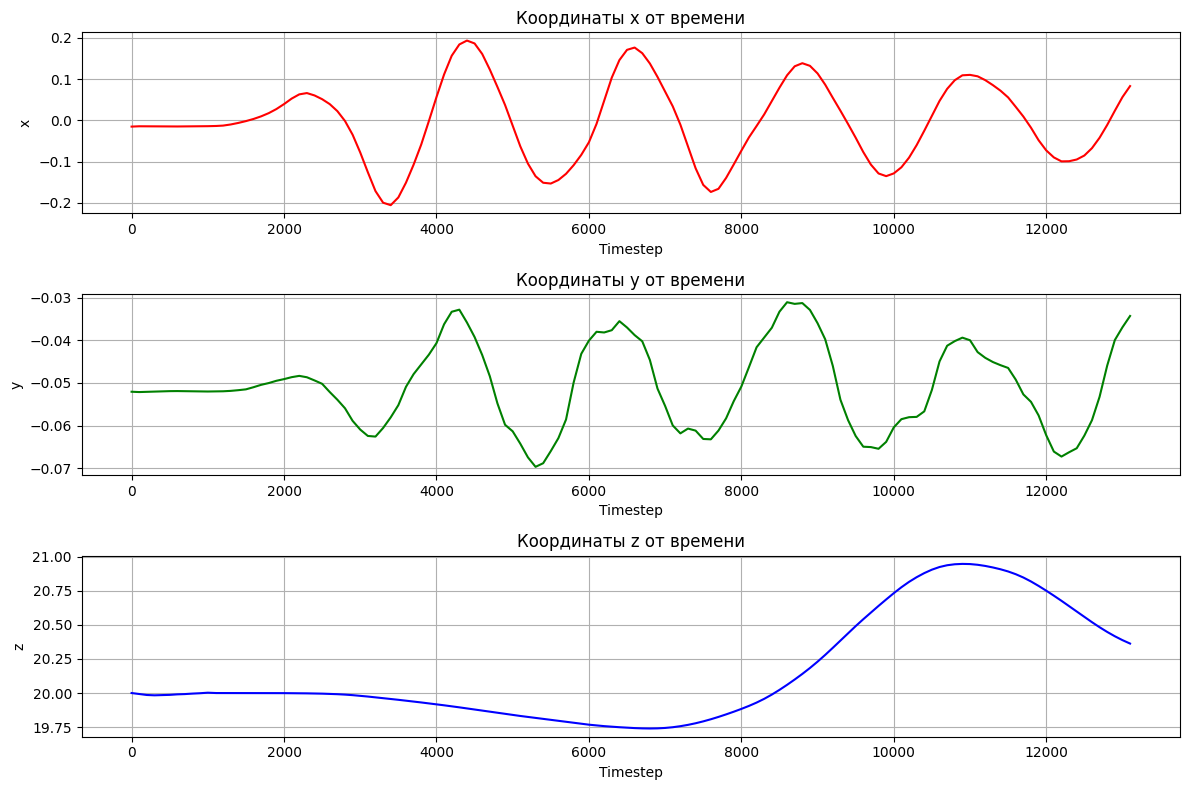

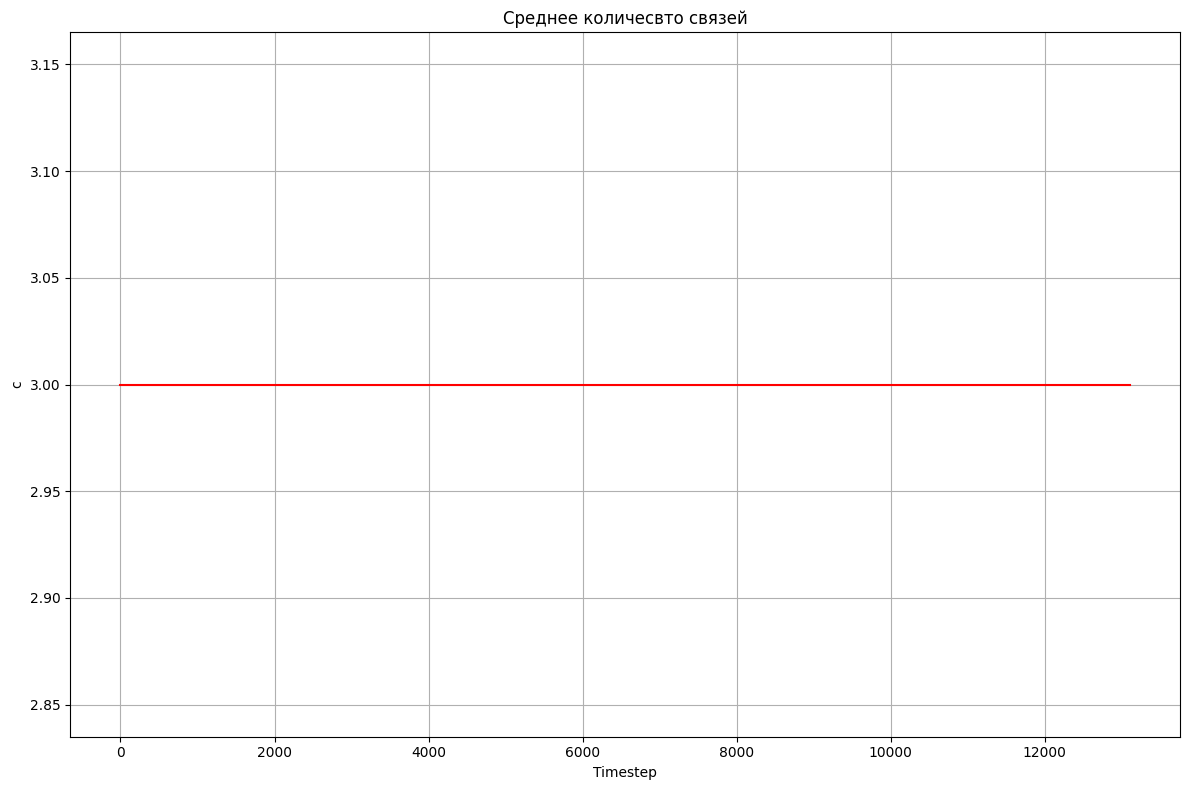

Фуллерен при Температуре 300, скорости 0.01 : сломан : False
Графен при Температуре 300, скорости 0.01 : сломан : False
Folder already exist.
Folder already exist.
In File generated.

Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_1.0_temp_300/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared


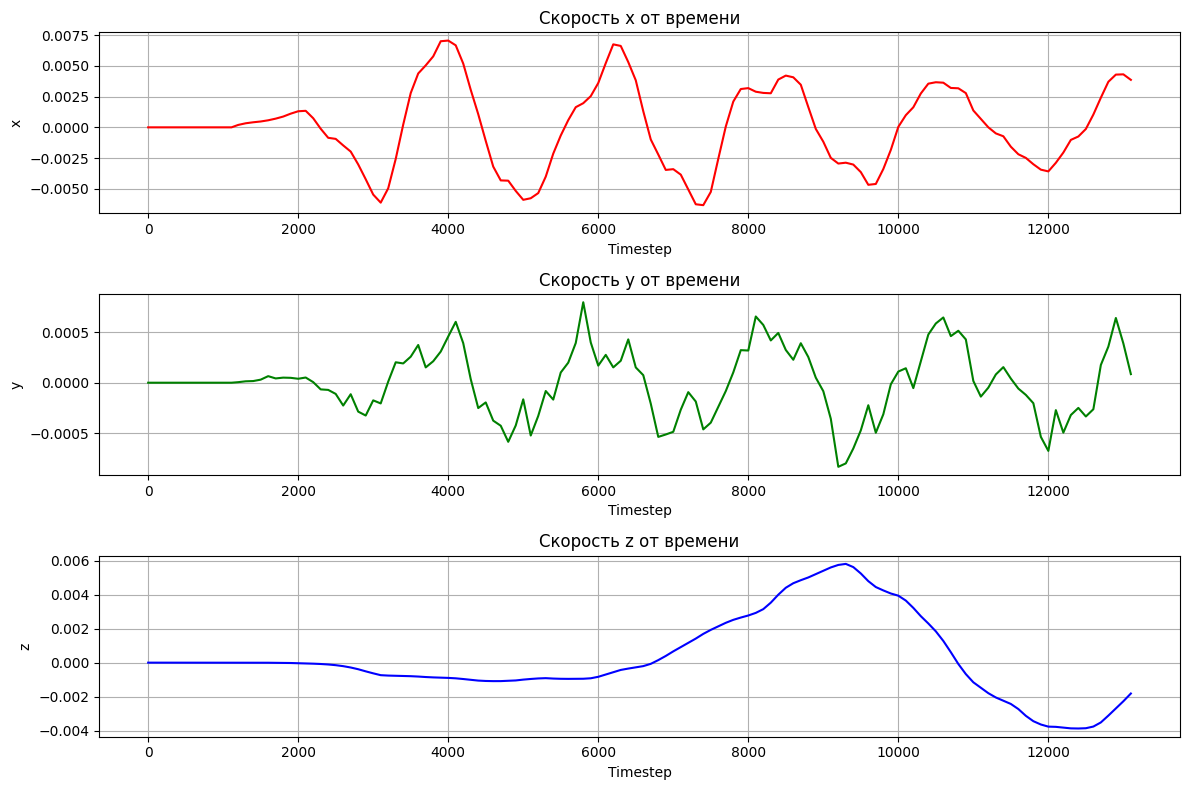

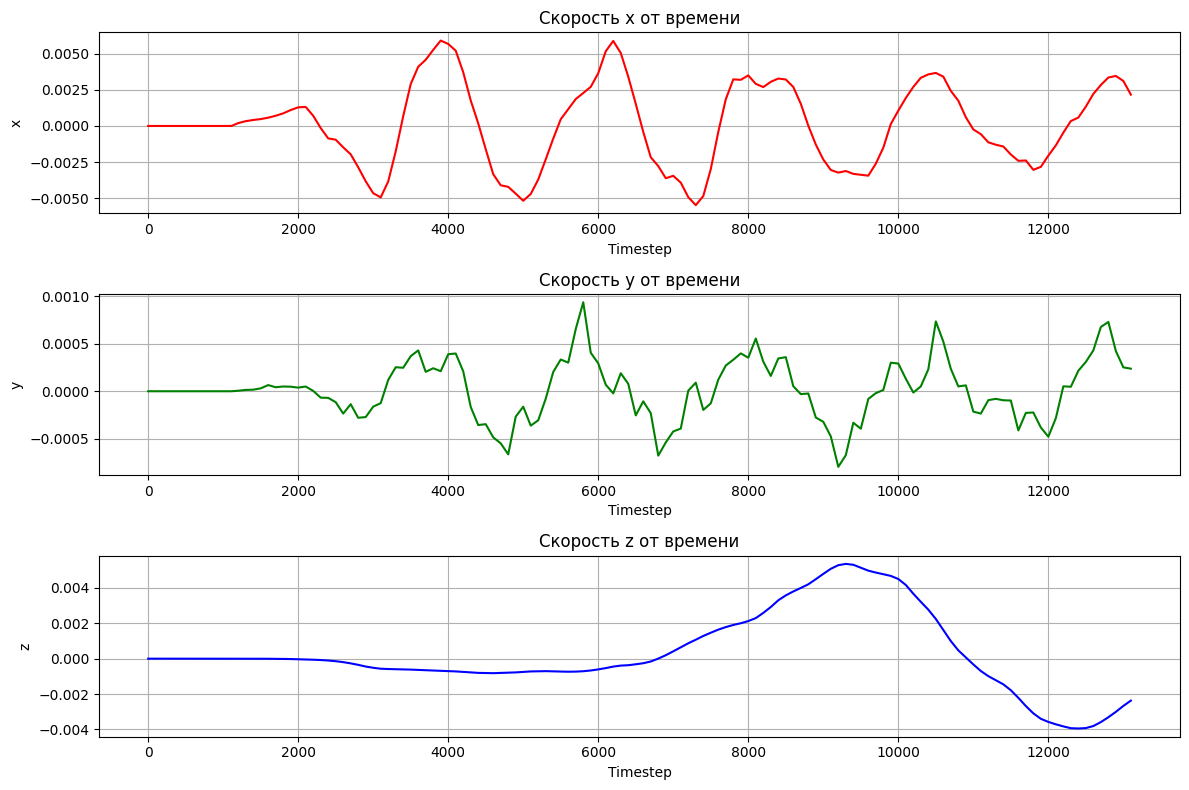

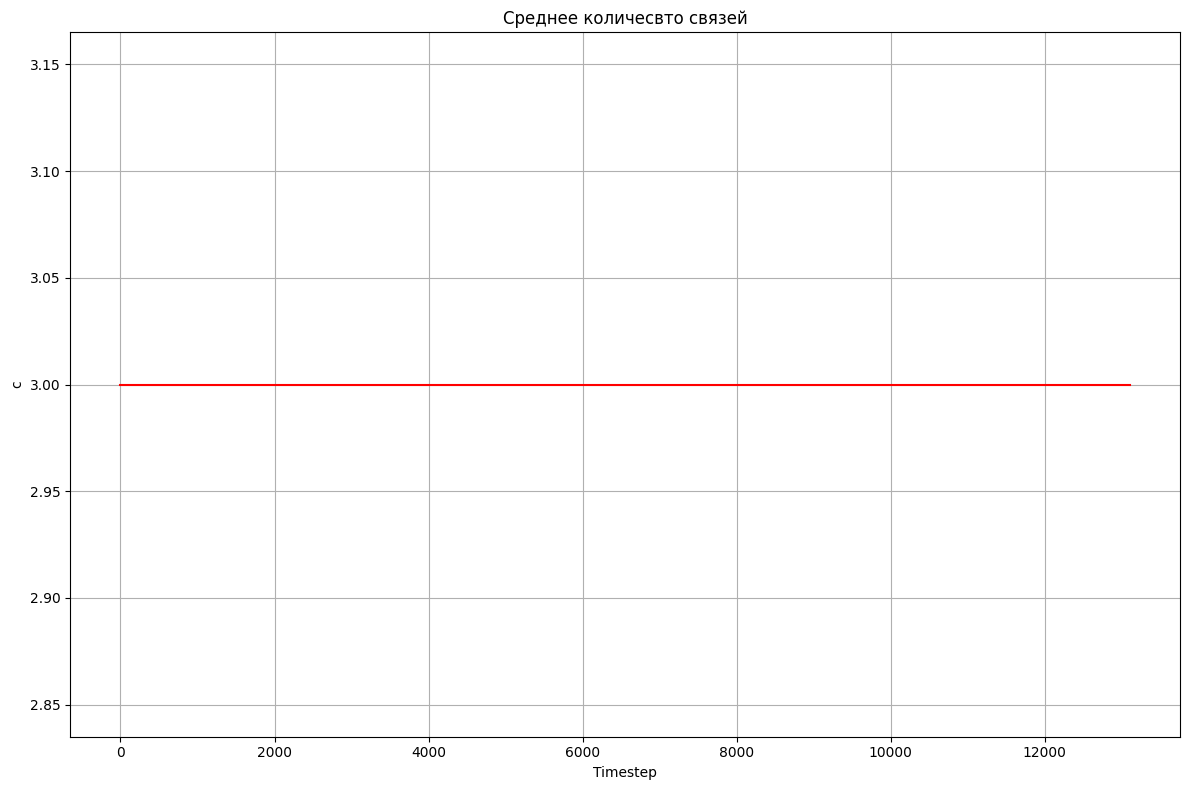

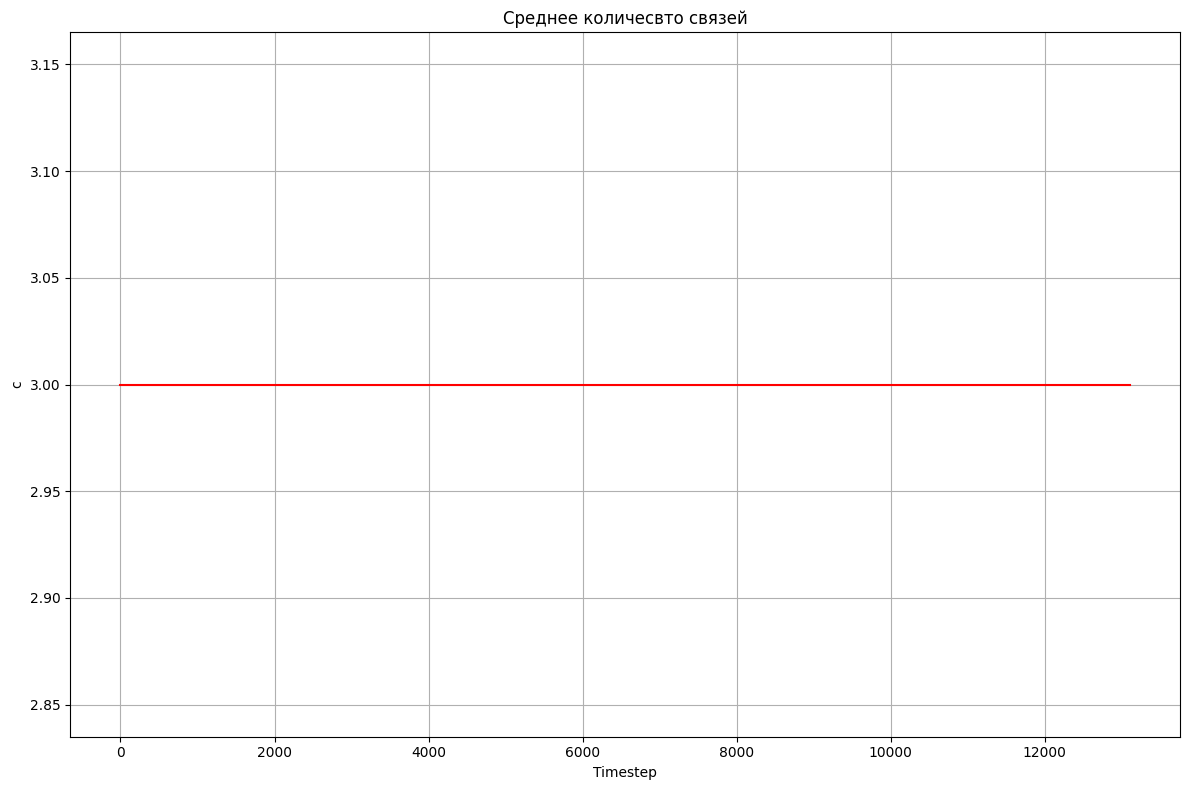

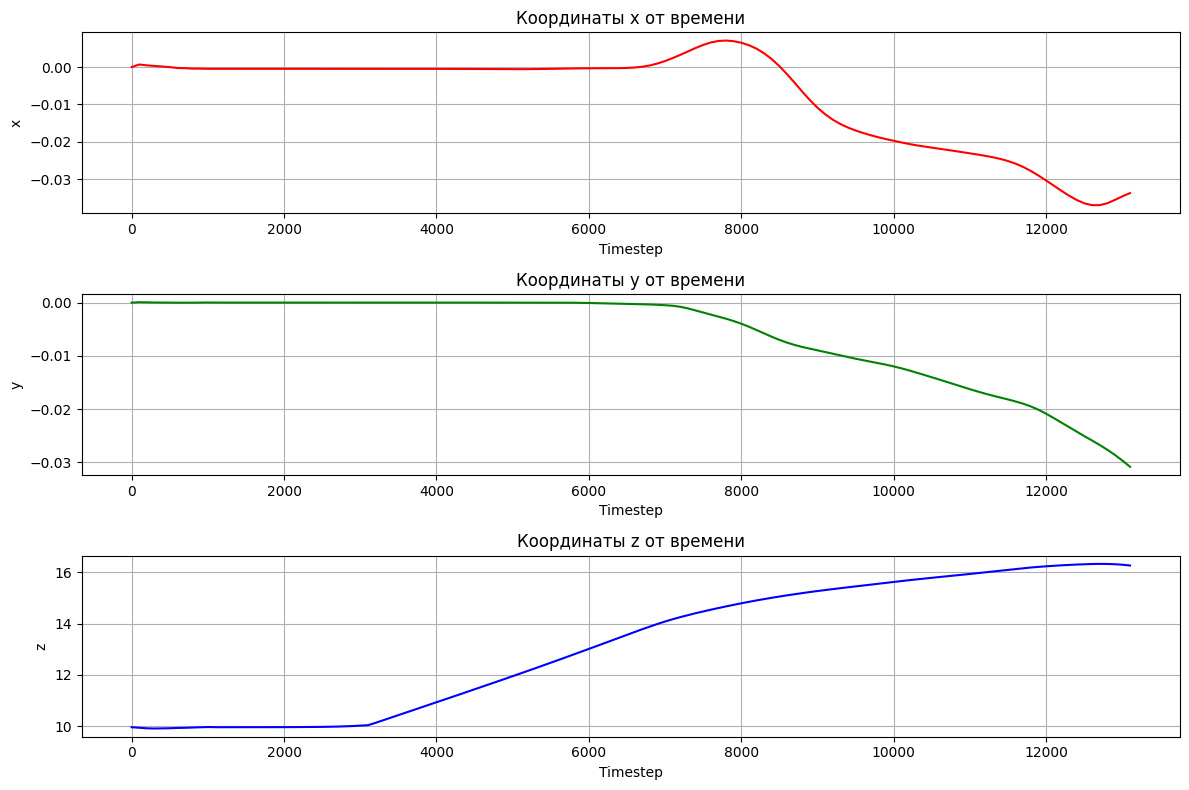

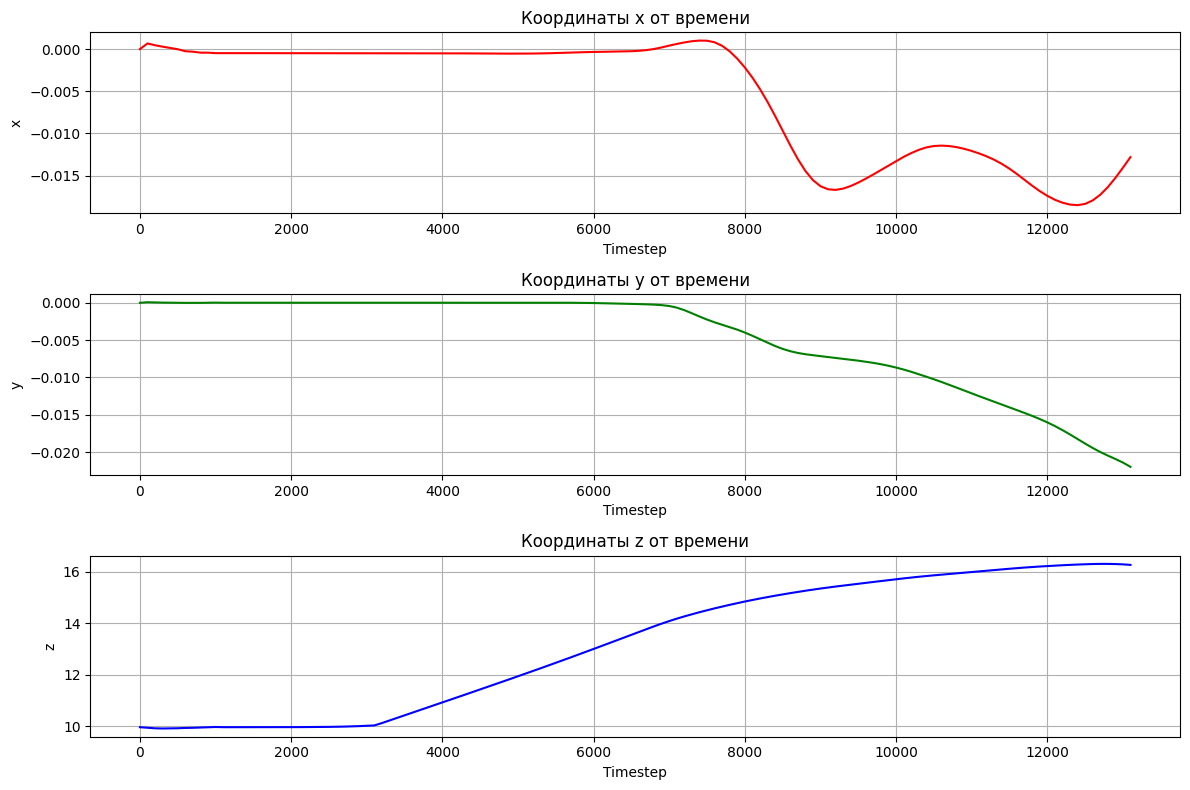

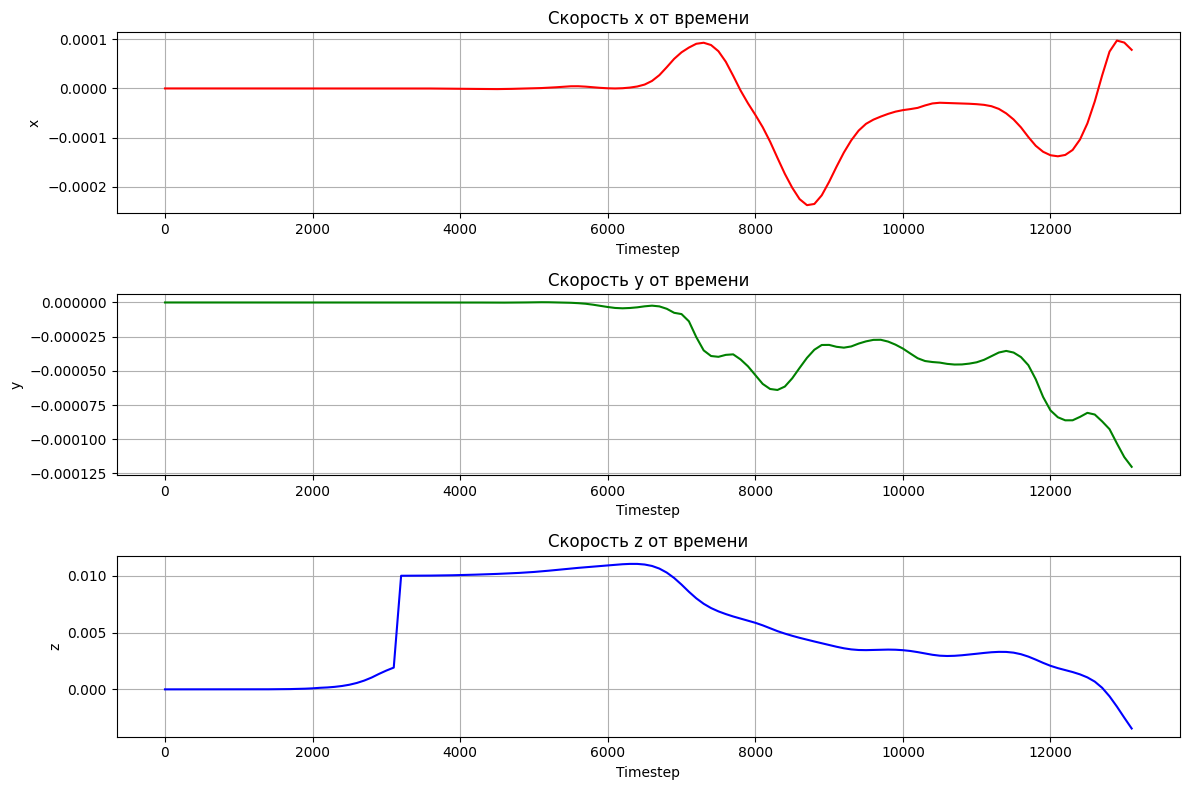

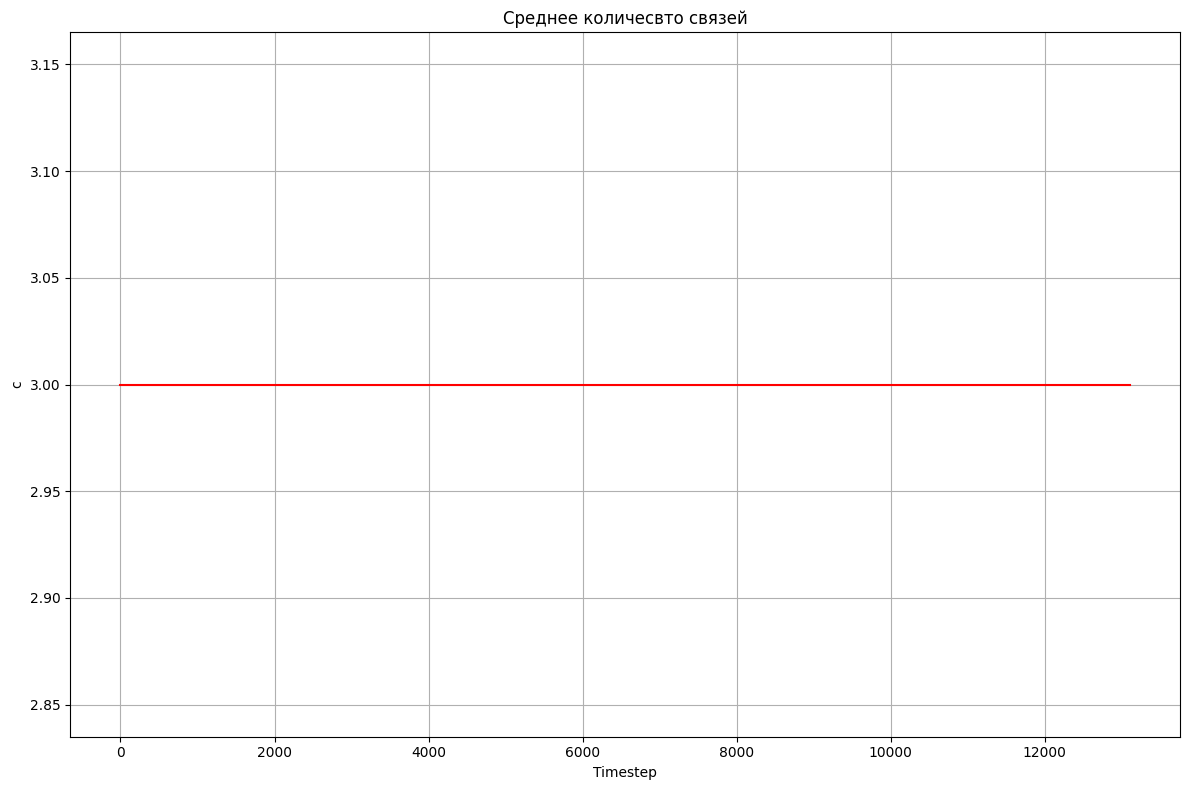

Фуллерен при Температуре 350, скорости 0.01 : сломан : False
Графен при Температуре 350, скорости 0.01 : сломан : False
Folder already exist.
Folder already exist.
In File generated.

Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_1.0_temp_350/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared


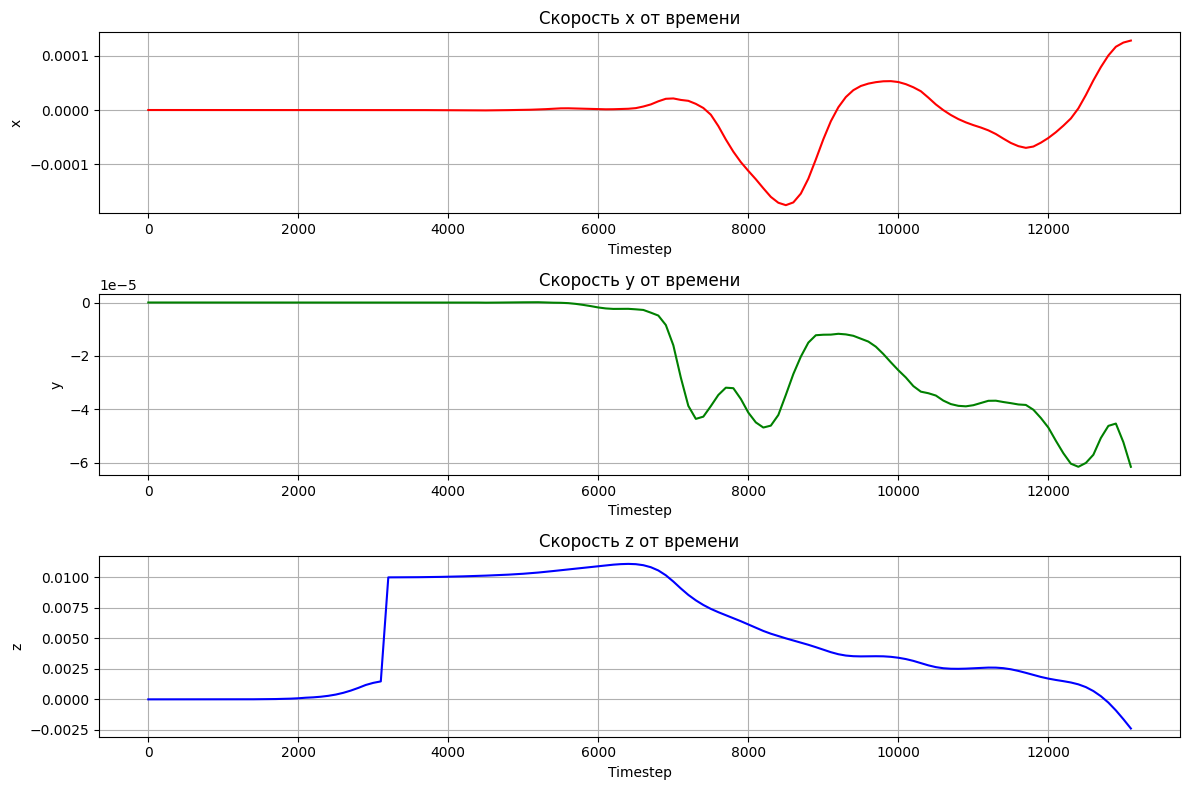

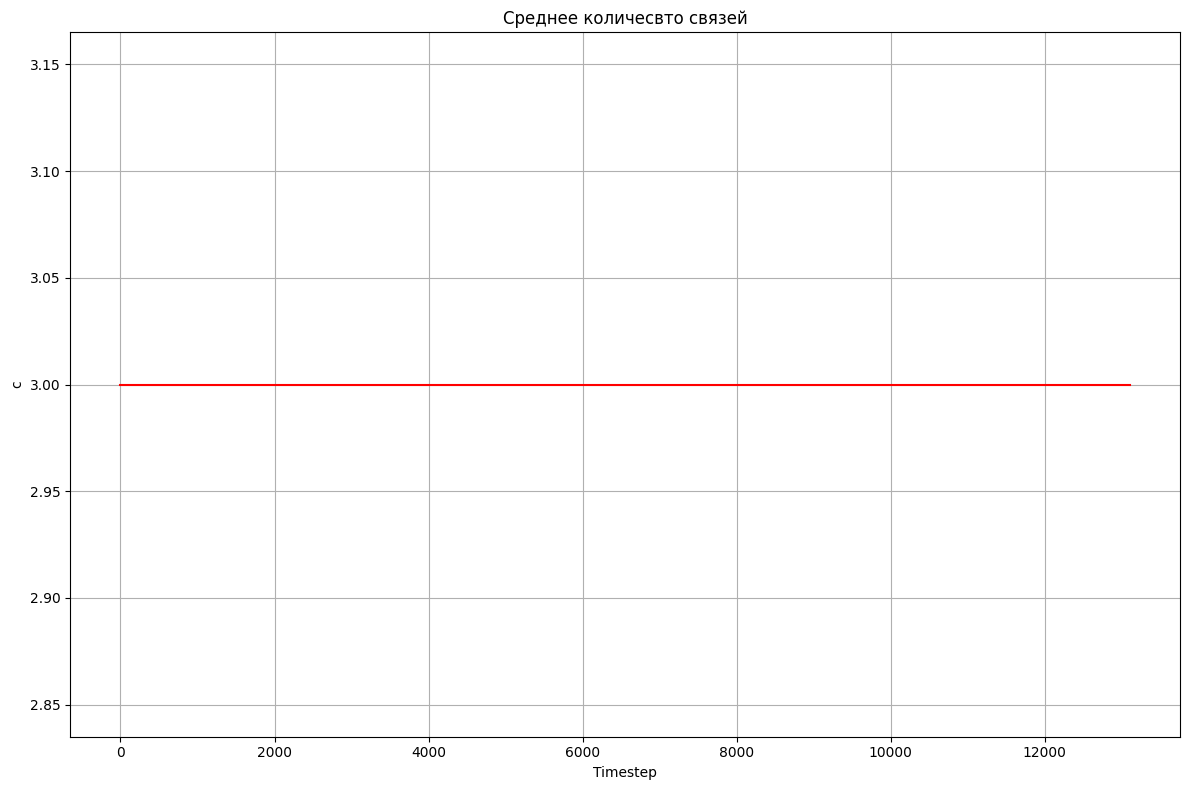

Фуллерен при Температуре 250, скорости 0.01 : сломан : False
Графен при Температуре 250, скорости 0.01 : сломан : False
Folder already exist.
Folder already exist.
In File generated.

Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_1.0_temp_250/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared
LAMMPS simulation for velocity 0.01 started successfully!
LAMMPS simulation for velocity 0.01 started successfully!


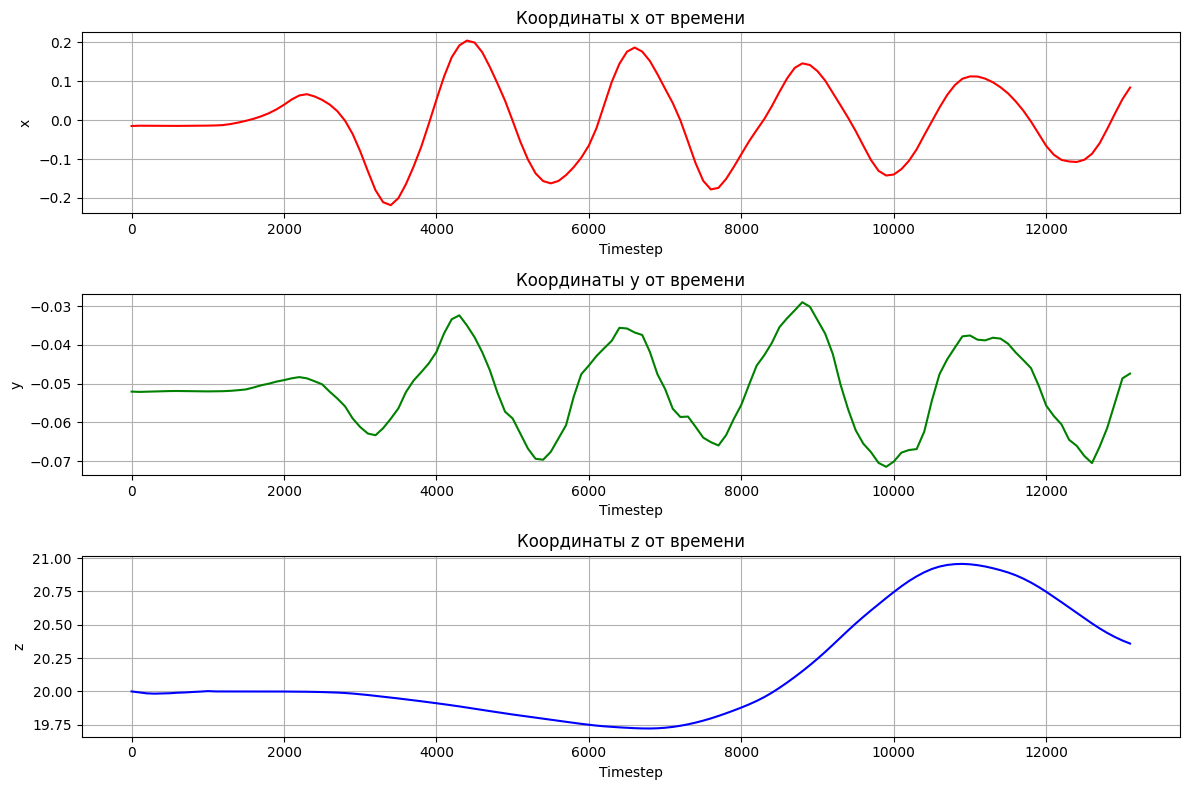

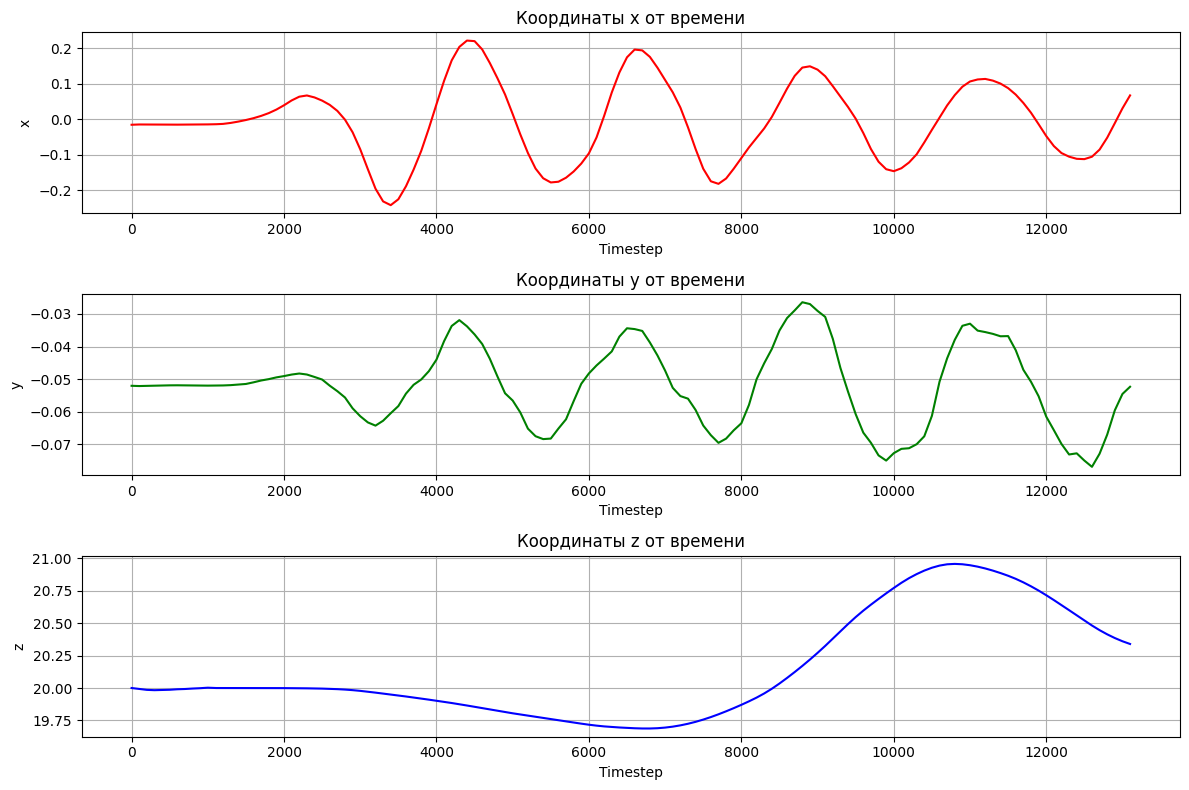

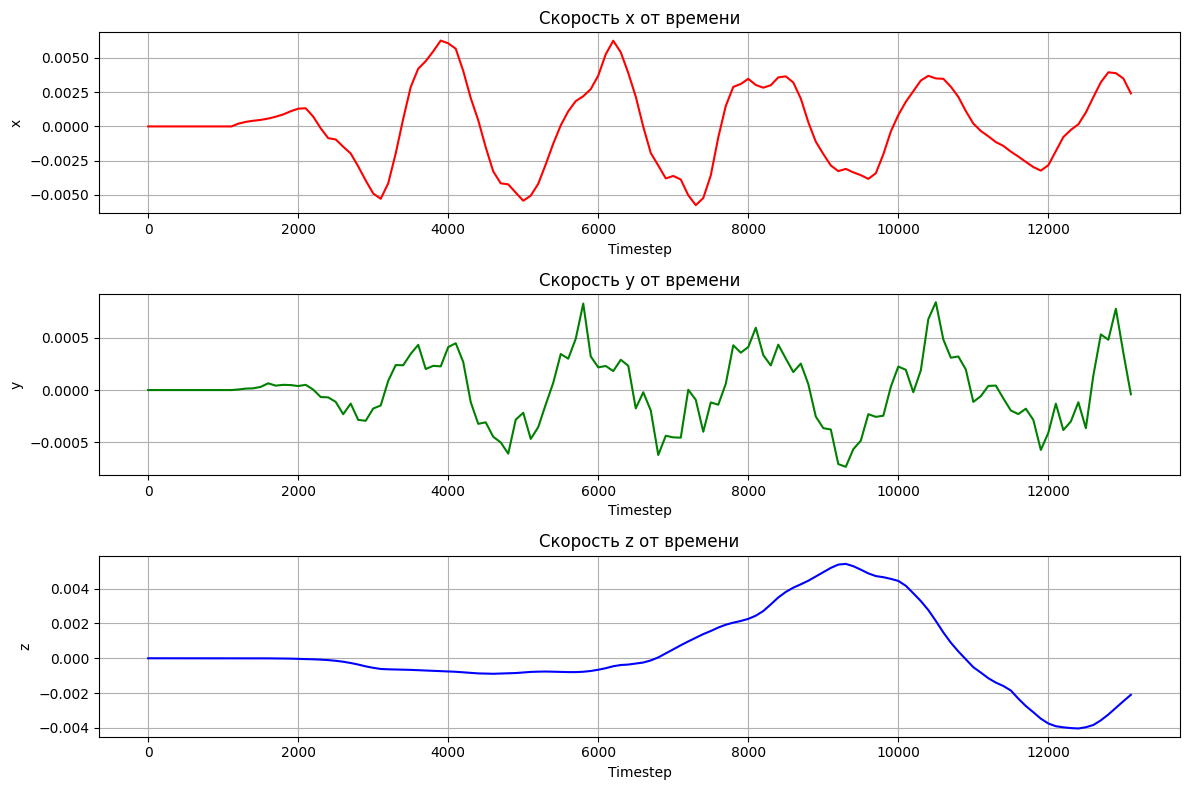

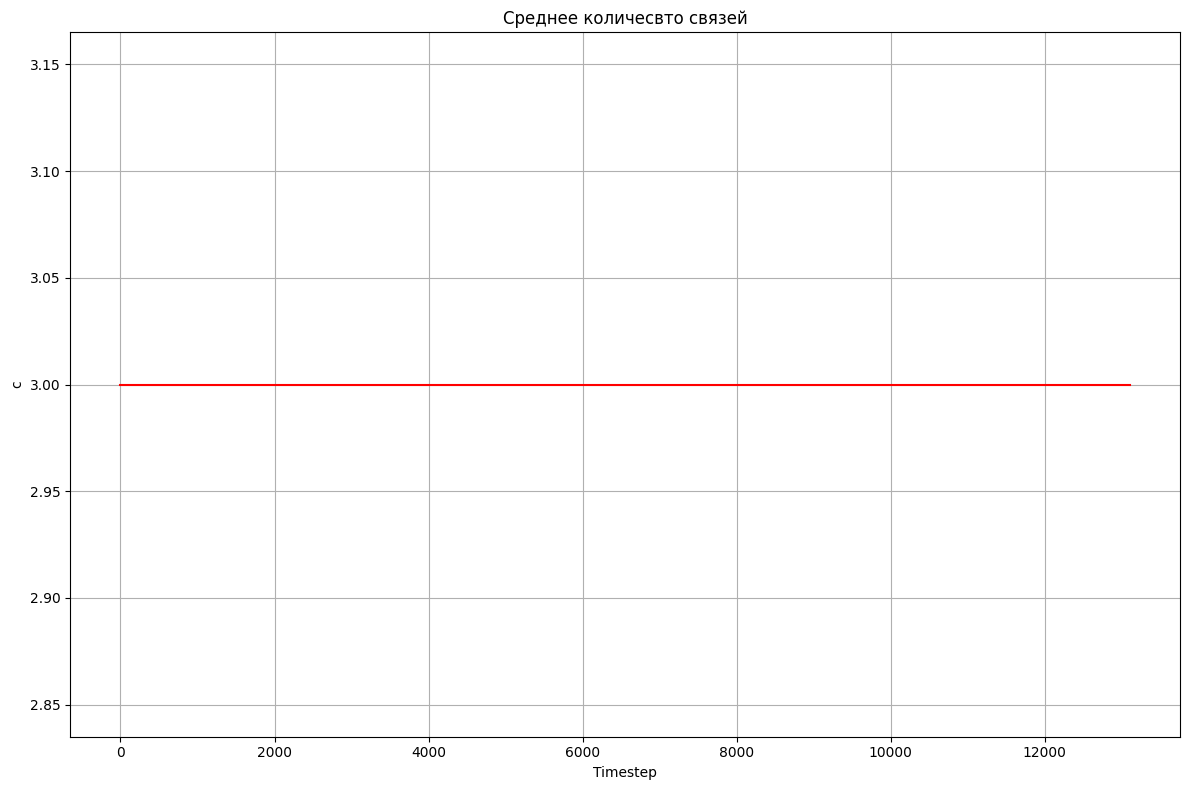

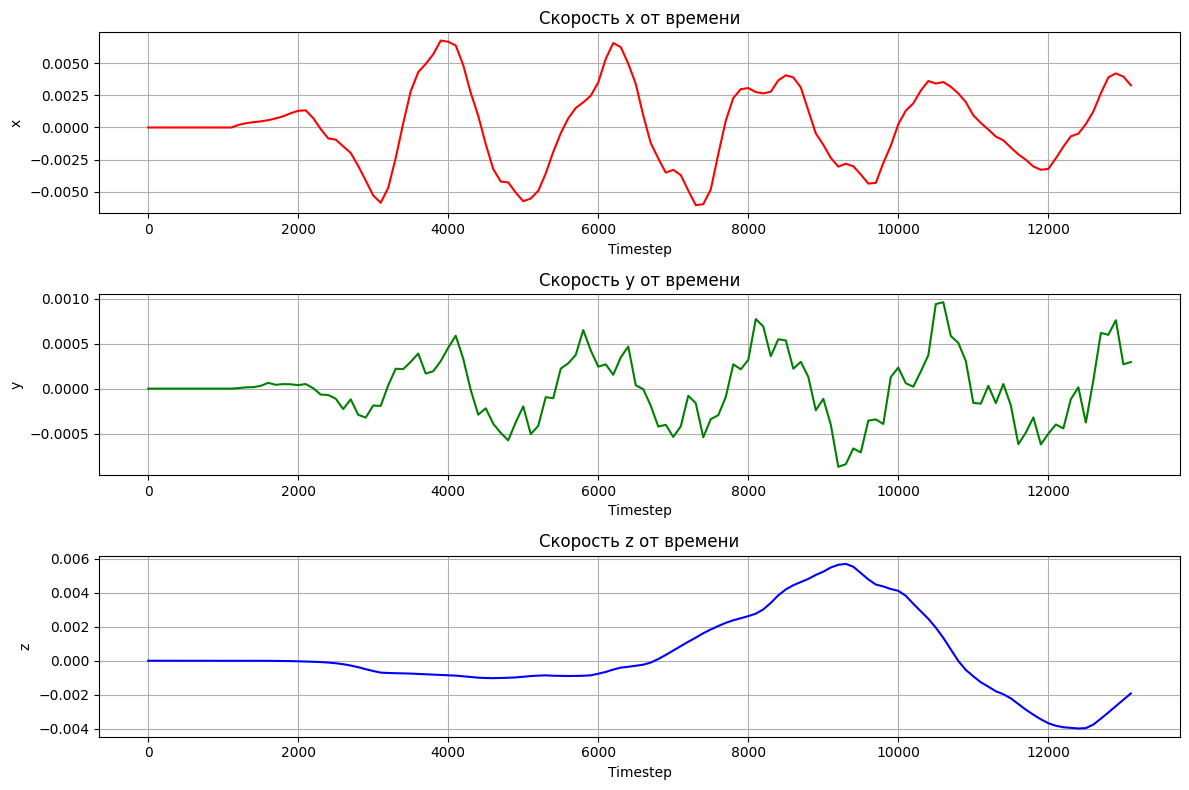

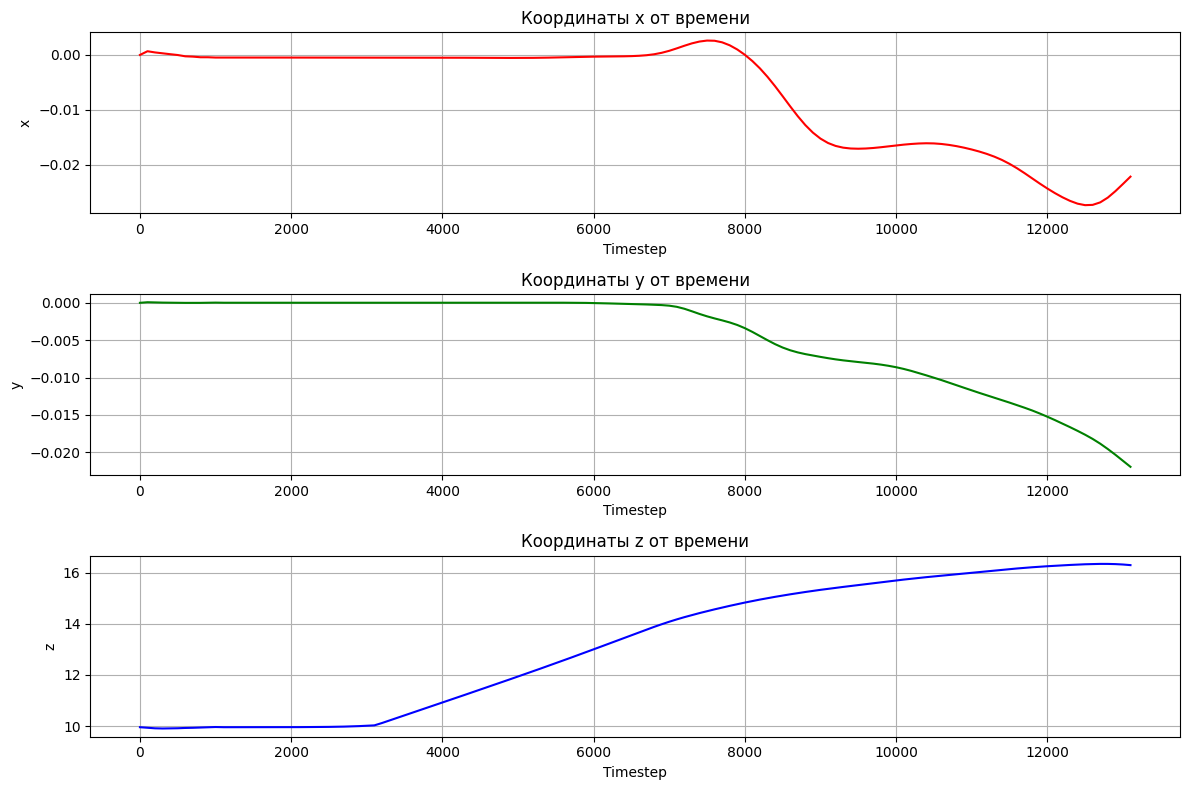

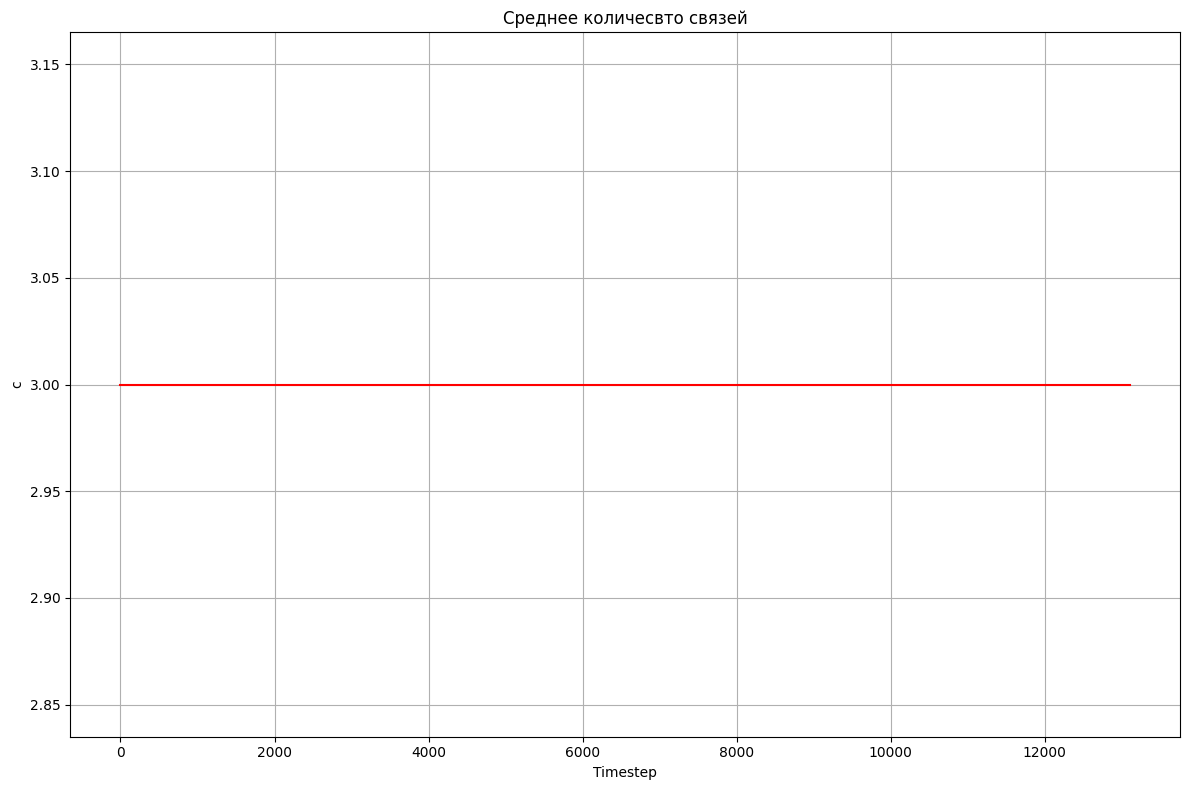

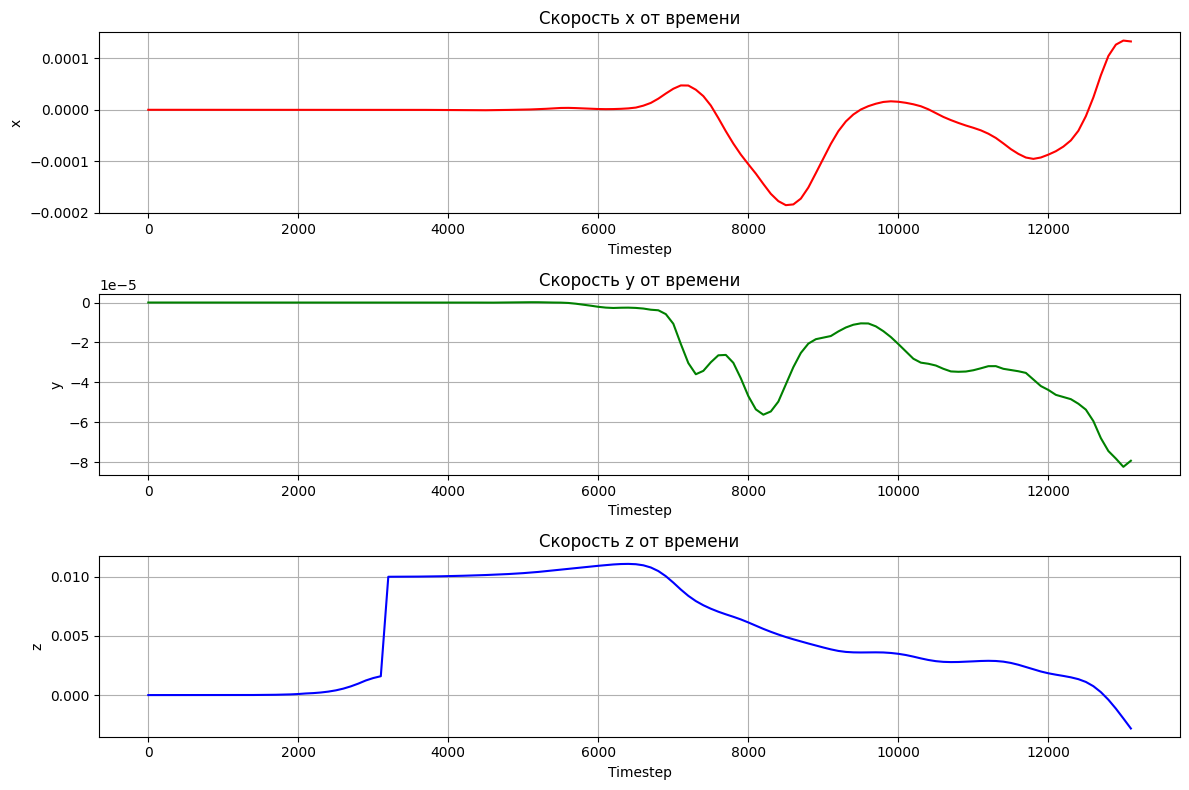

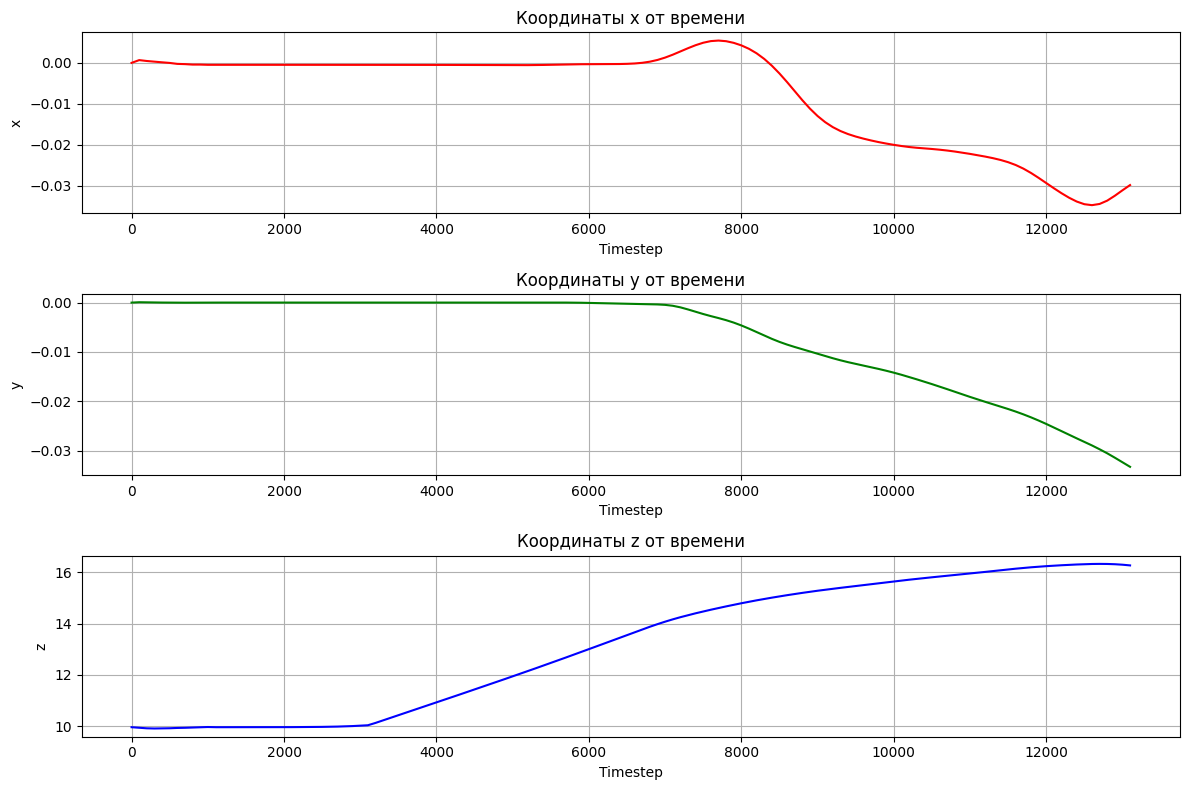

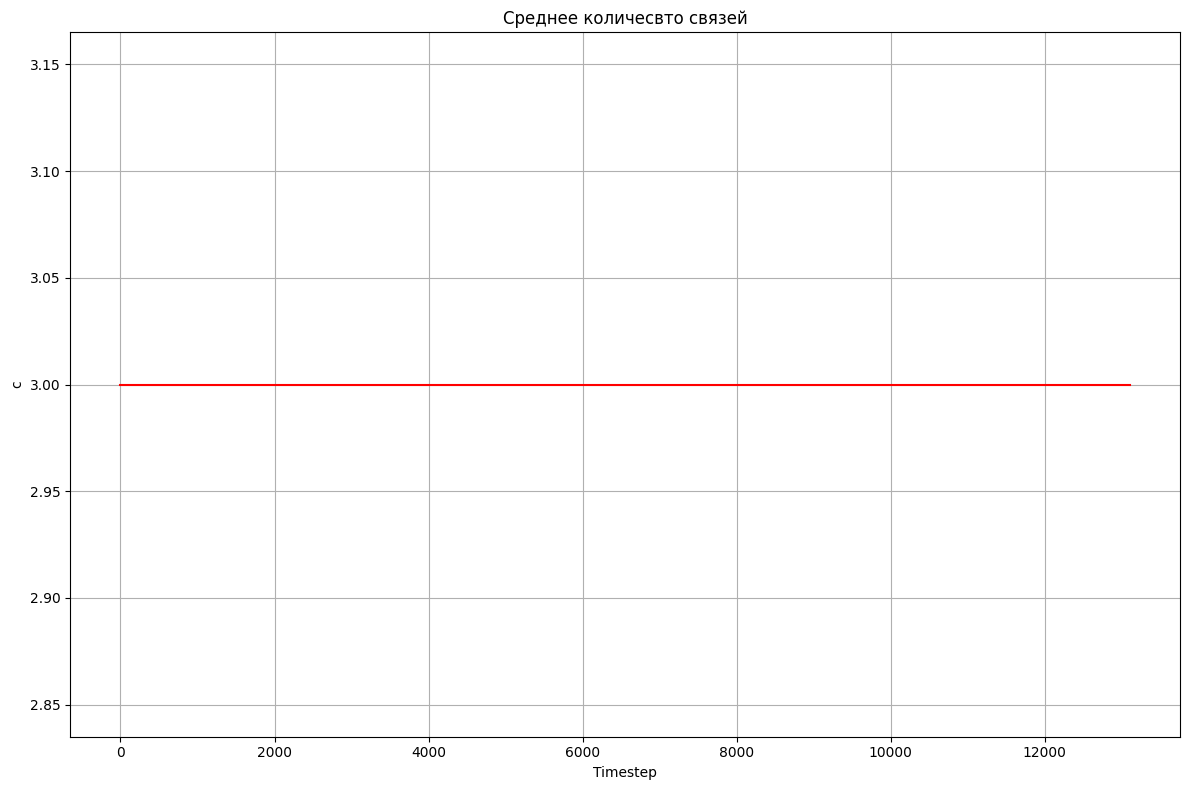

Фуллерен при Температуре 275, скорости 0.01 : сломан : False
Графен при Температуре 275, скорости 0.01 : сломан : False
Folder already exist.
Folder already exist.
In File generated.

Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_1.0_temp_275/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared


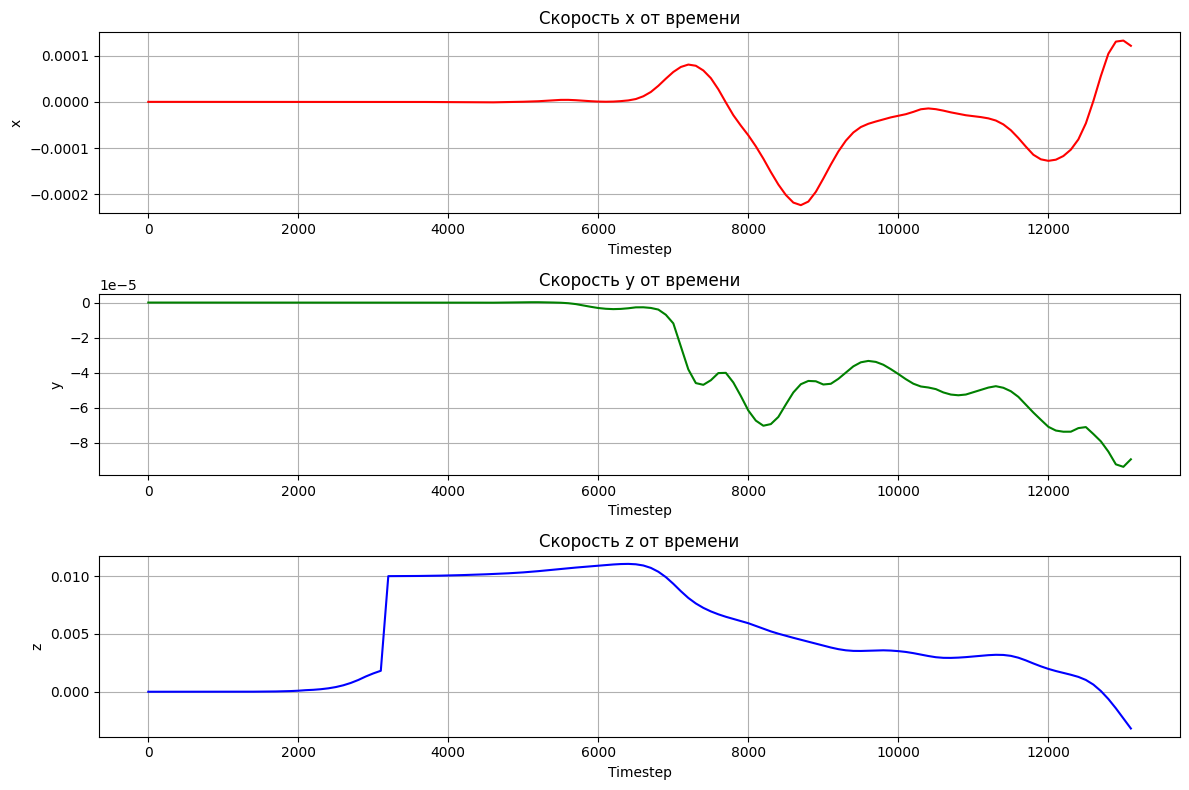

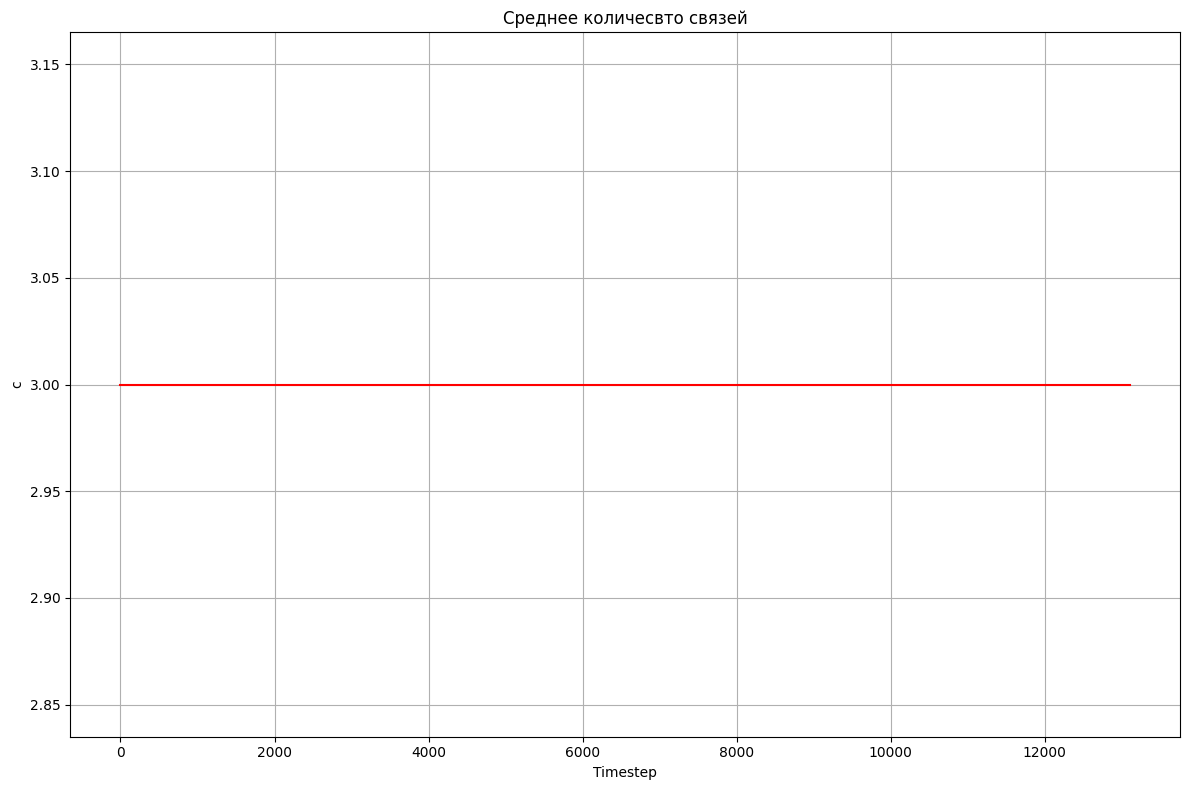

Фуллерен при Температуре 325, скорости 0.01 : сломан : False
Графен при Температуре 325, скорости 0.01 : сломан : False
Folder already exist.
Folder already exist.
In File generated.

Preparing data started.

Graphene structure with 270 atoms has been written to runs/test_1/vel_1.0_temp_325/graphene.data.
Graphene has generated. Centering data started.

Data centered. Merging data started.

Data prepared
LAMMPS simulation for velocity 1.0 started successfully!


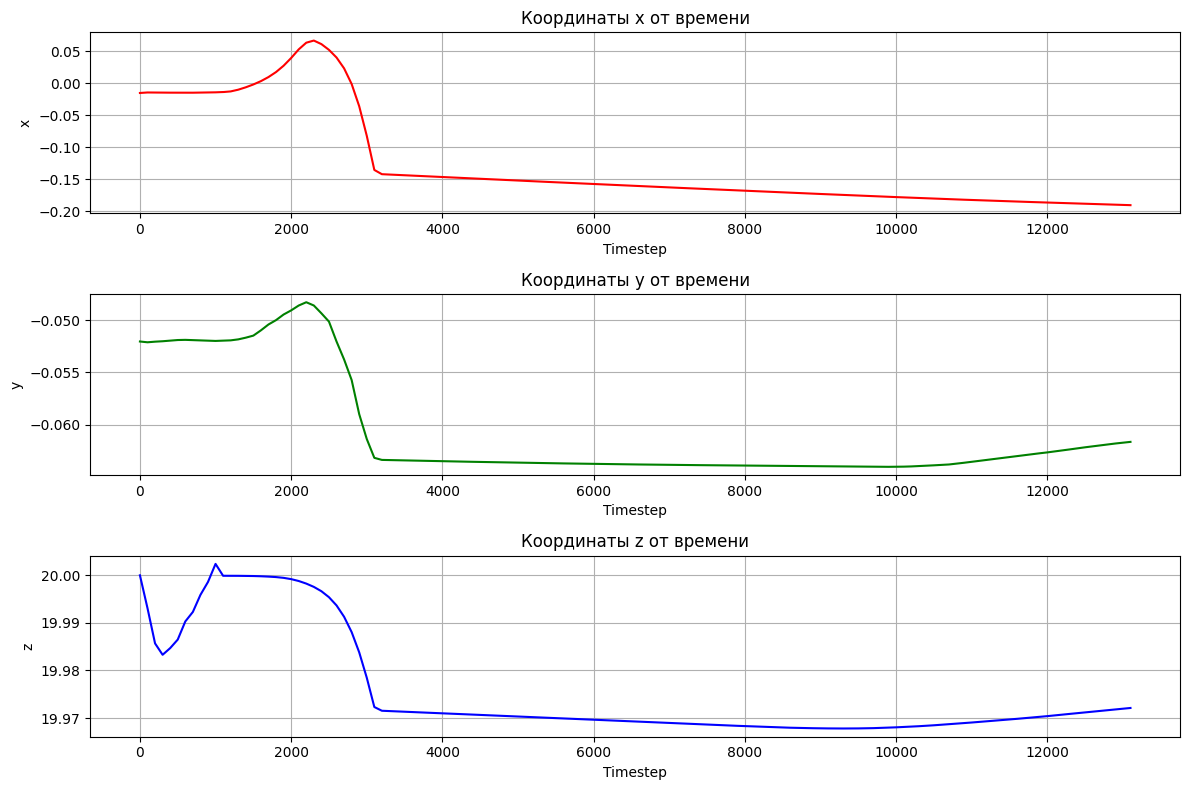

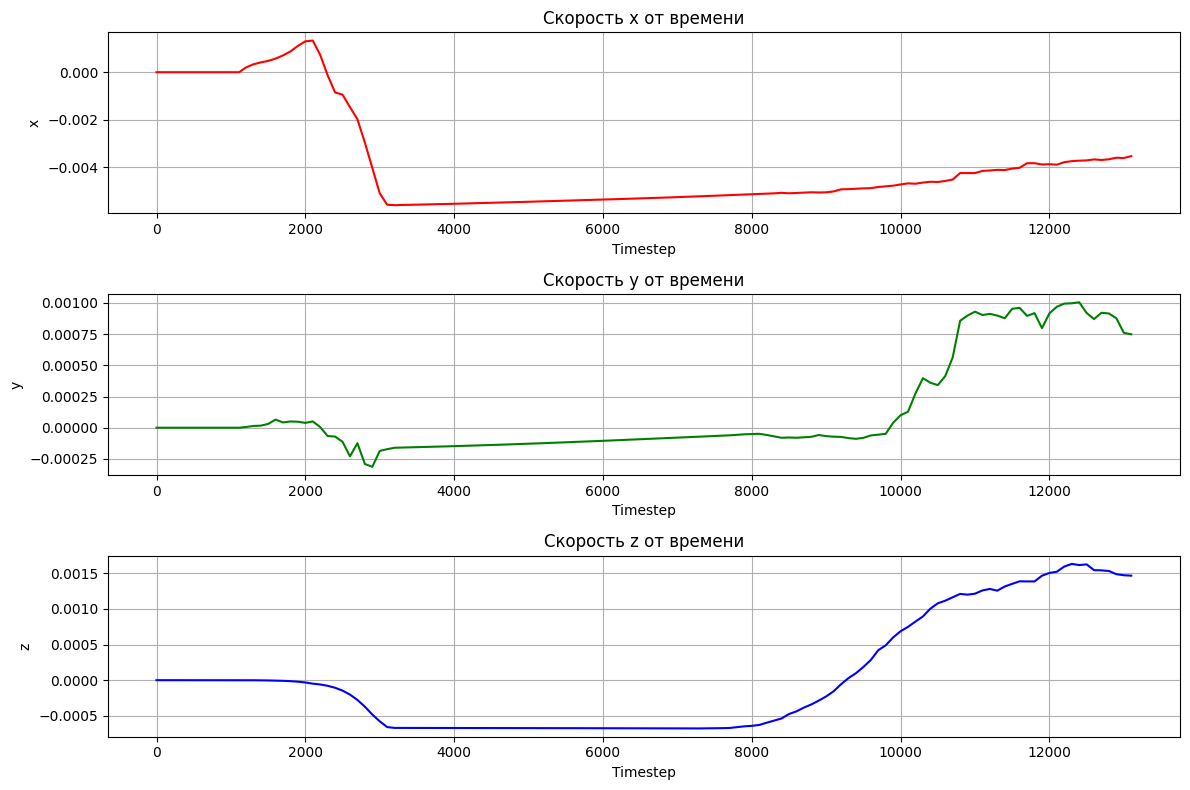

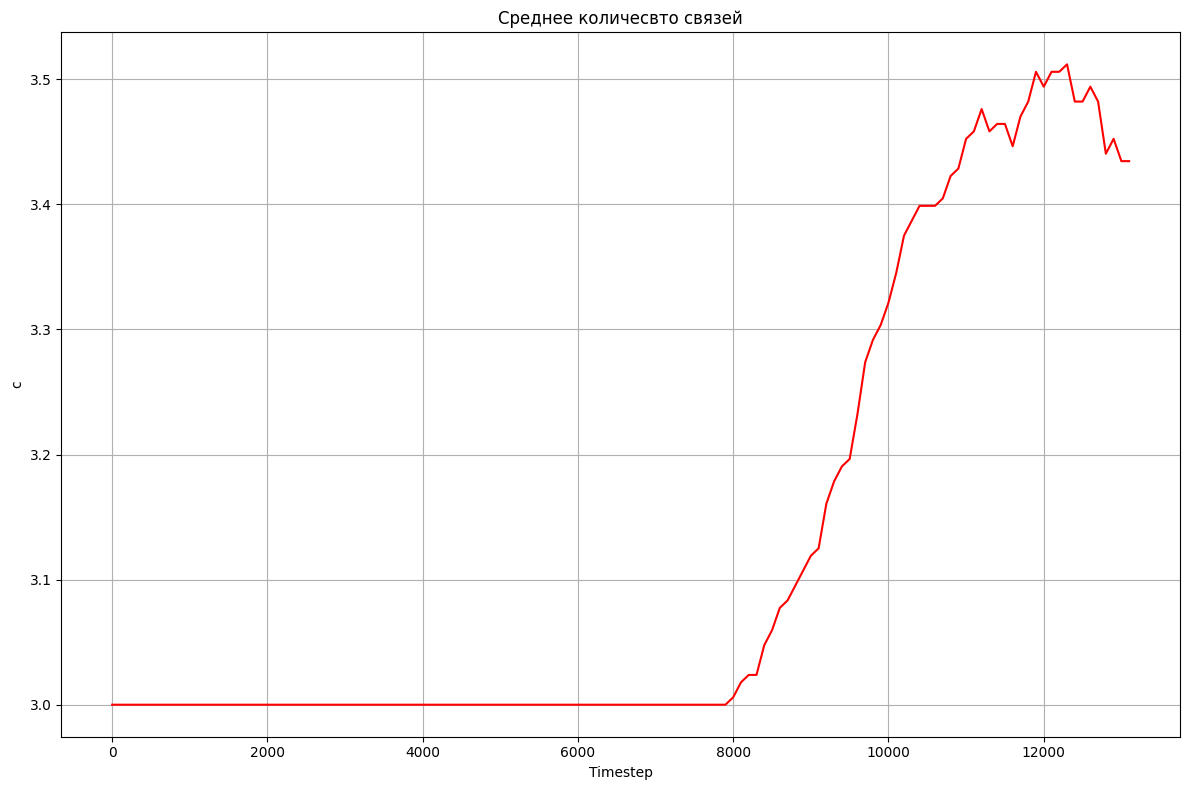

LAMMPS simulation for velocity 1.0 started successfully!


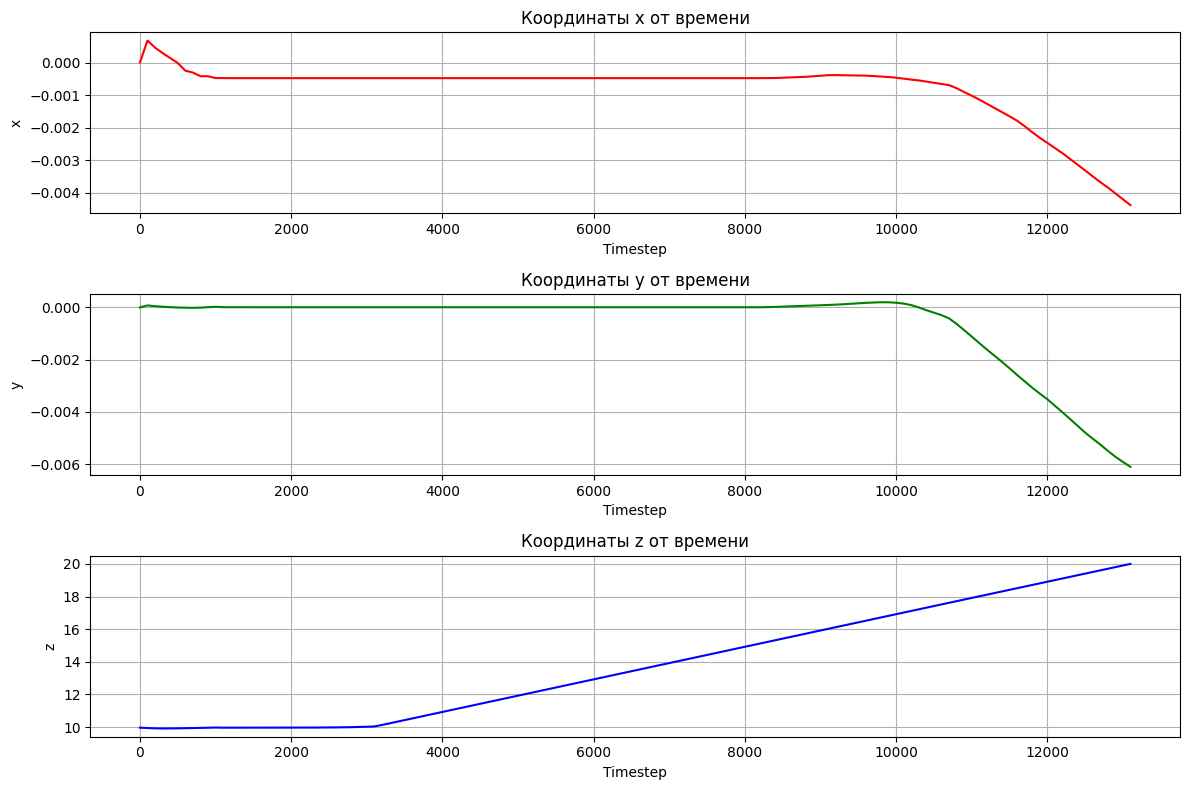

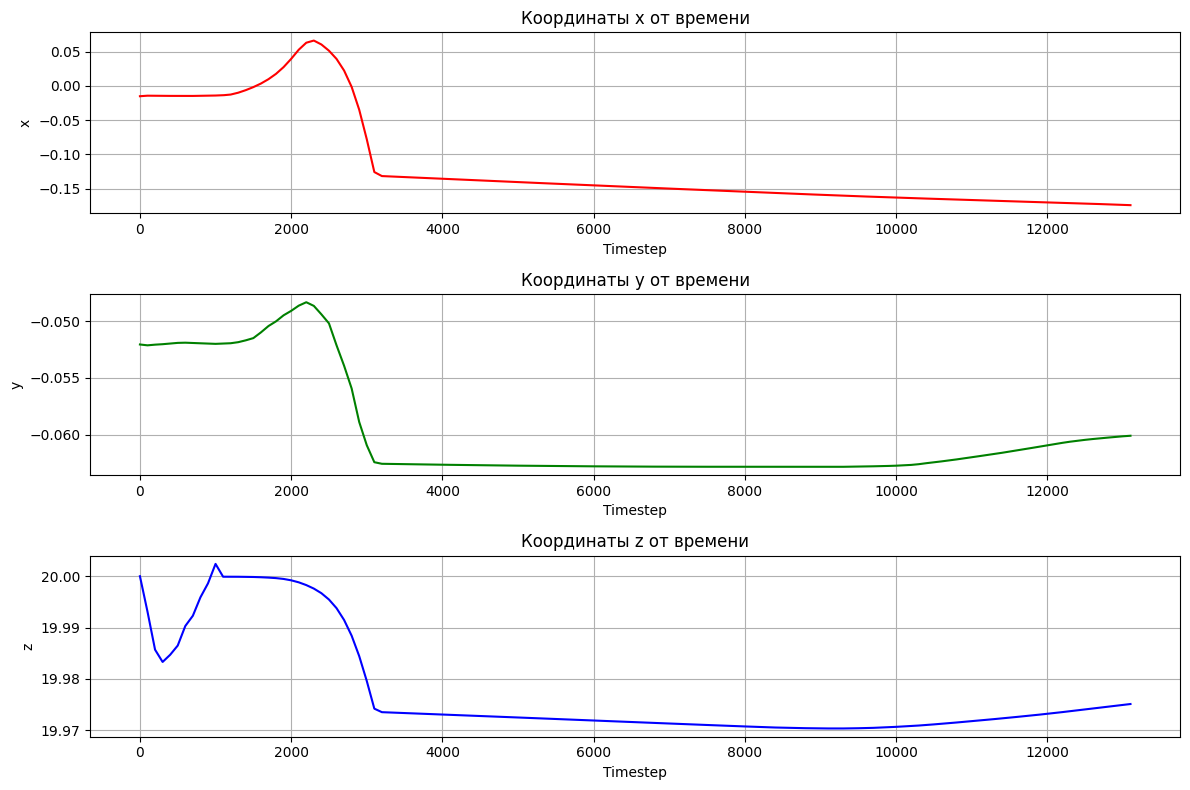

LAMMPS simulation for velocity 1.0 started successfully!


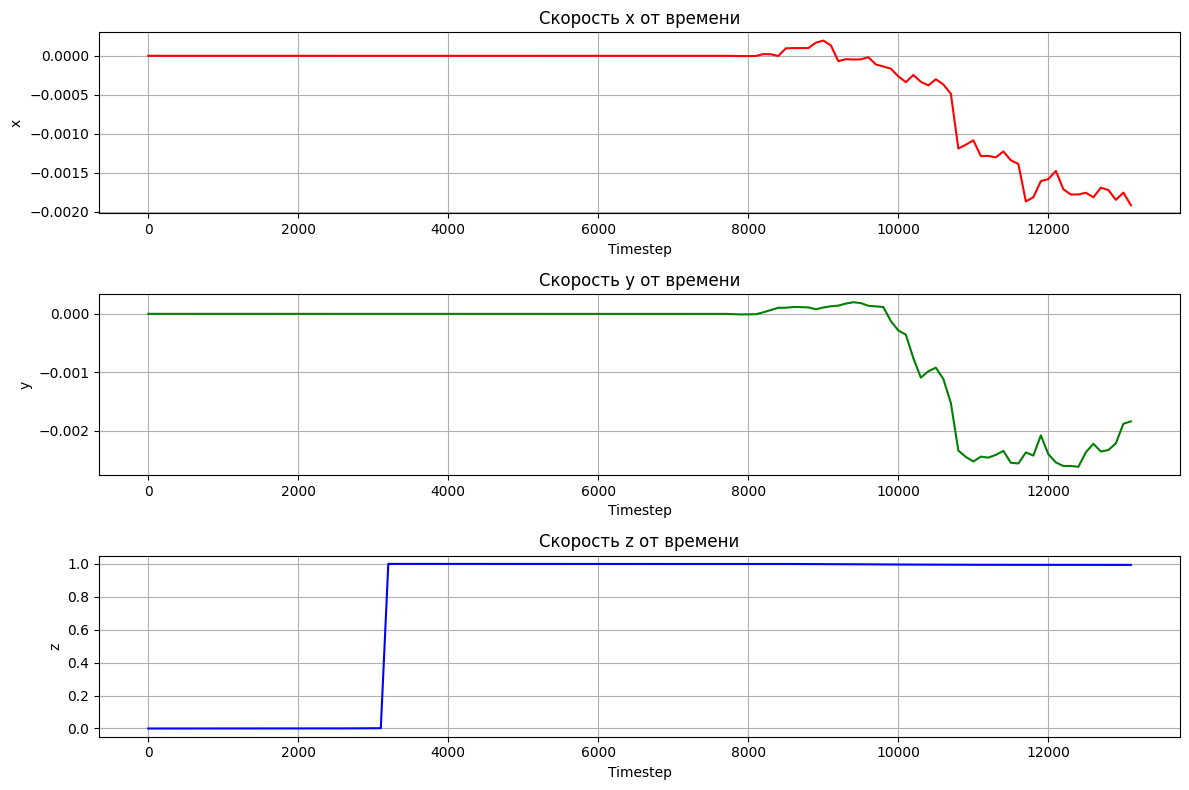

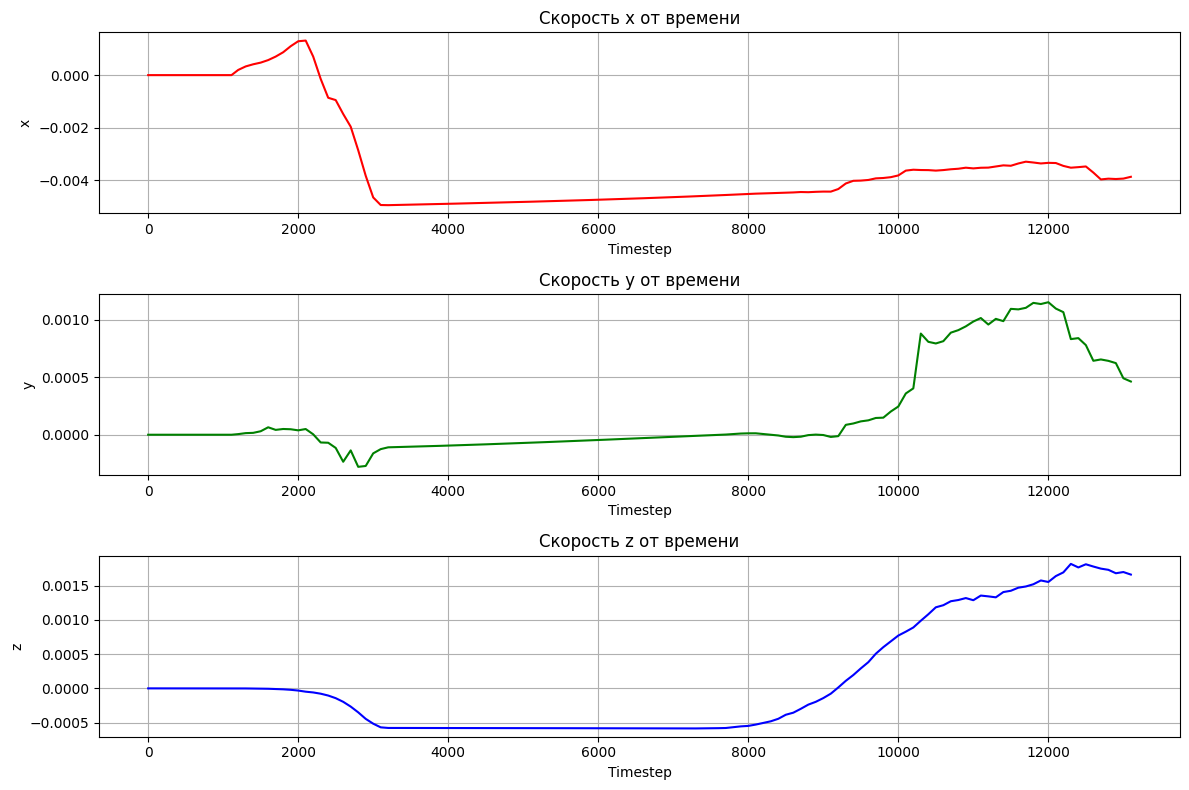

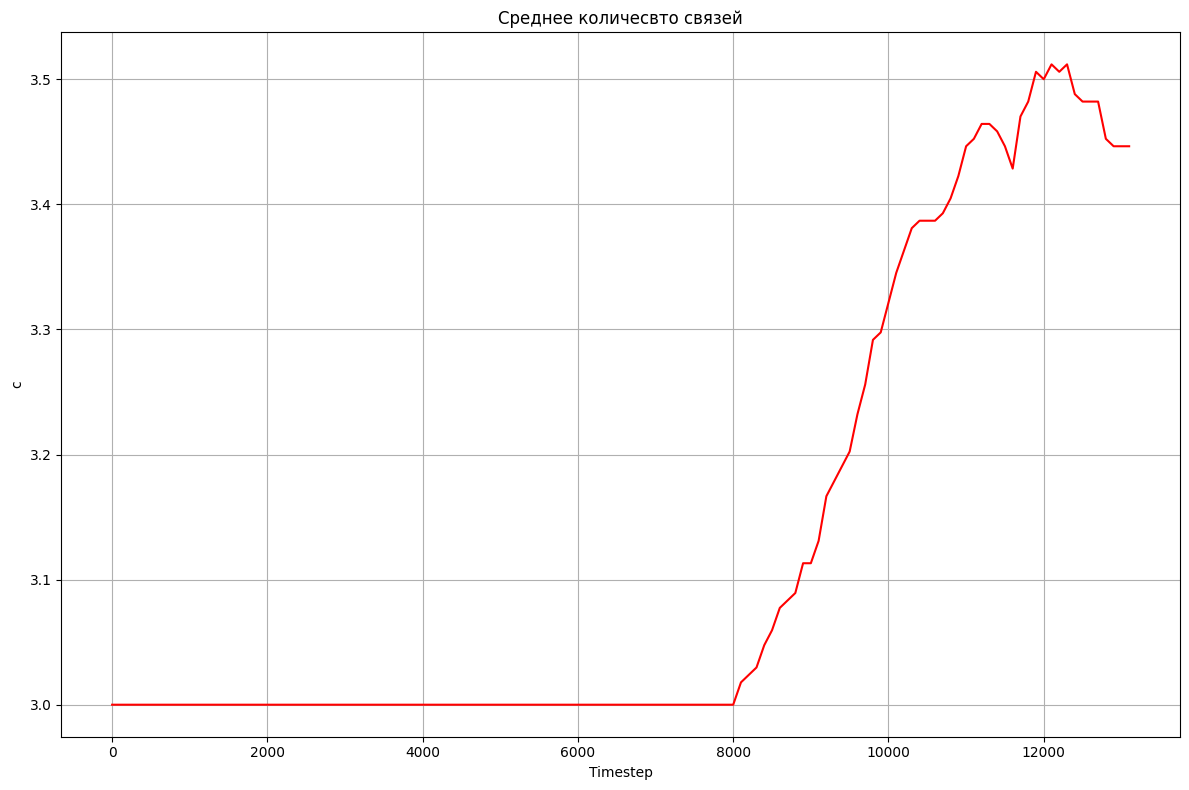

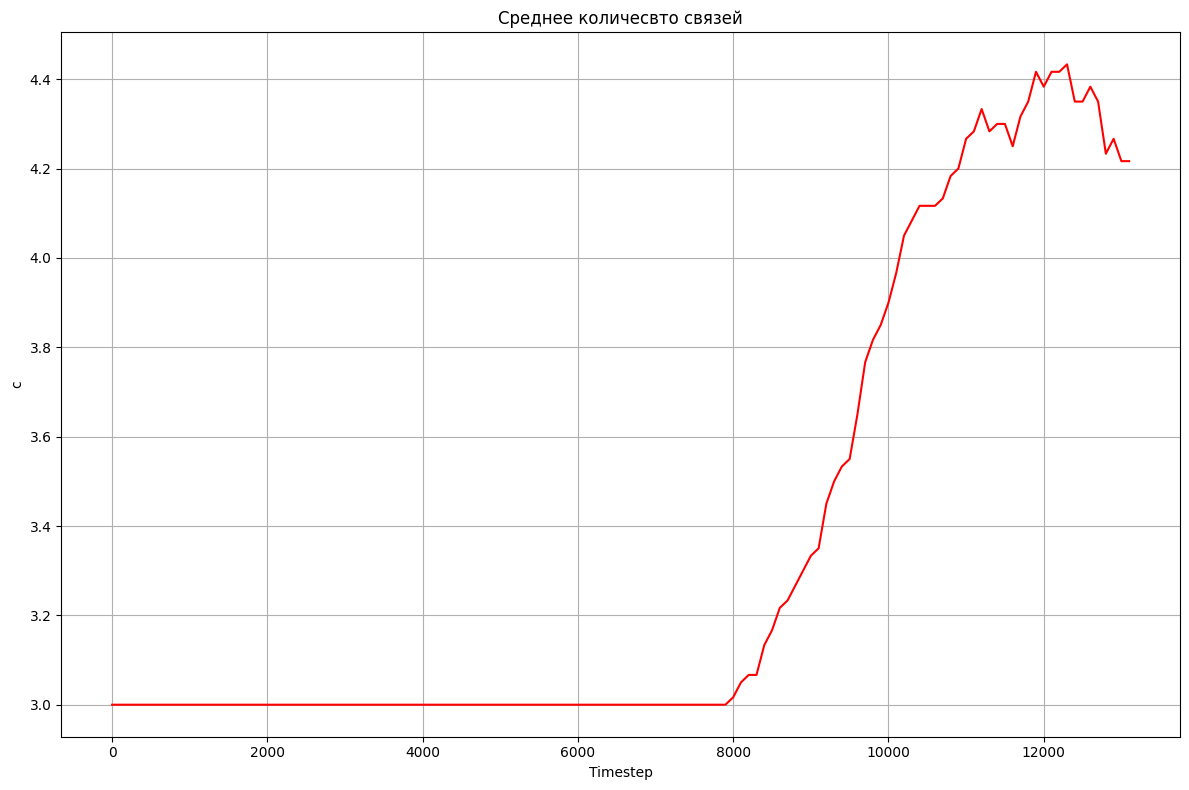

Фуллерен при Температуре 300, скорости 1.0 : сломан : False
Графен при Температуре 300, скорости 1.0 : сломан : False


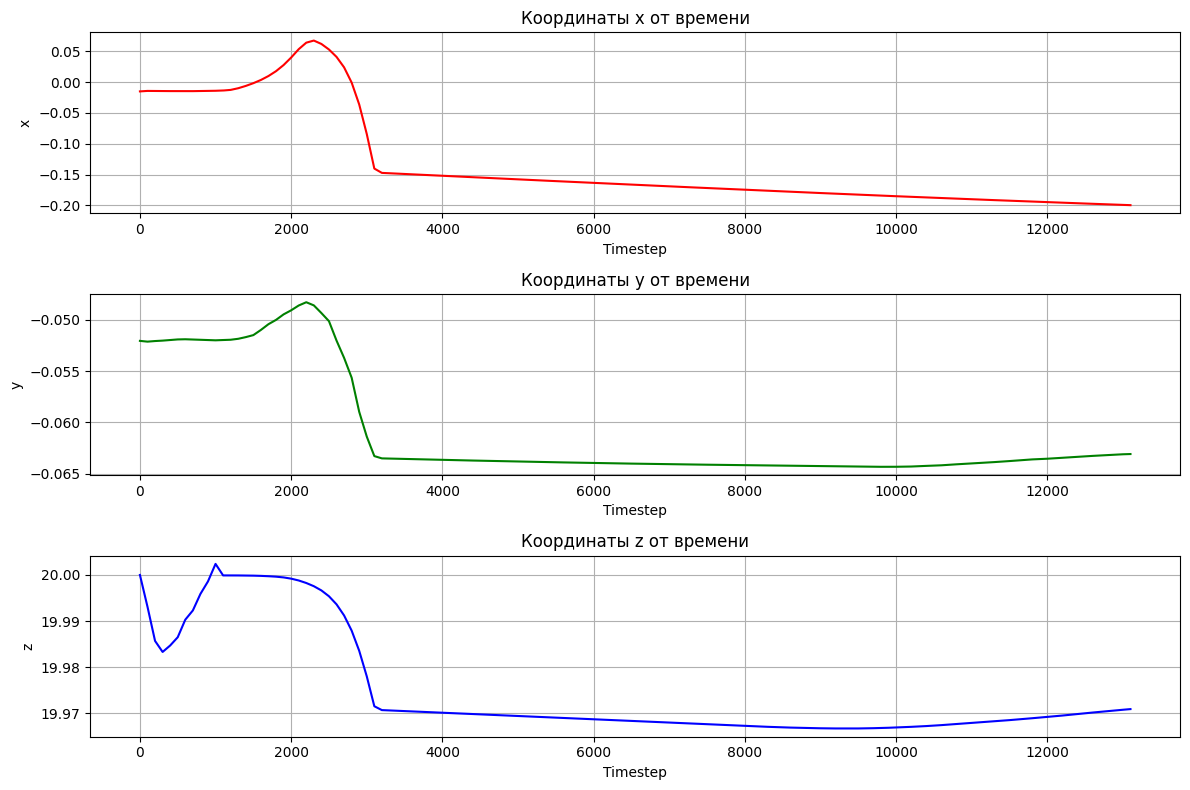

LAMMPS simulation for velocity 1.0 started successfully!


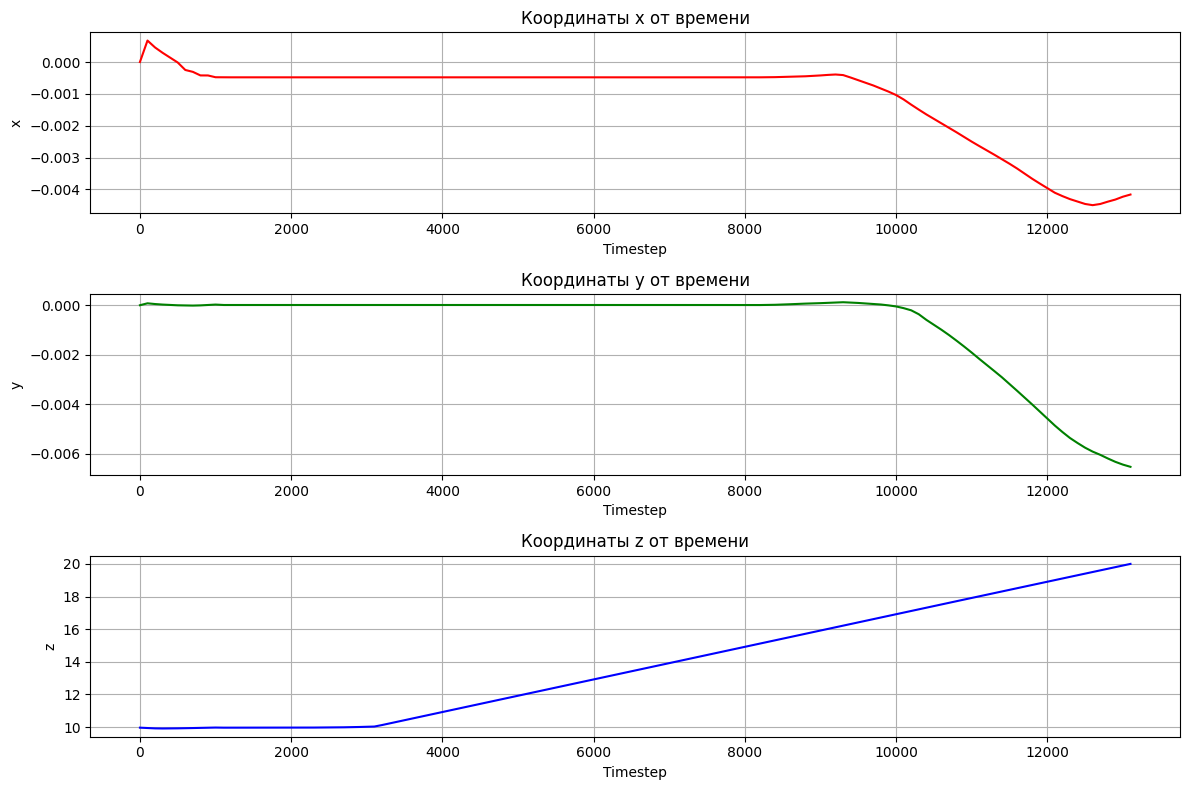

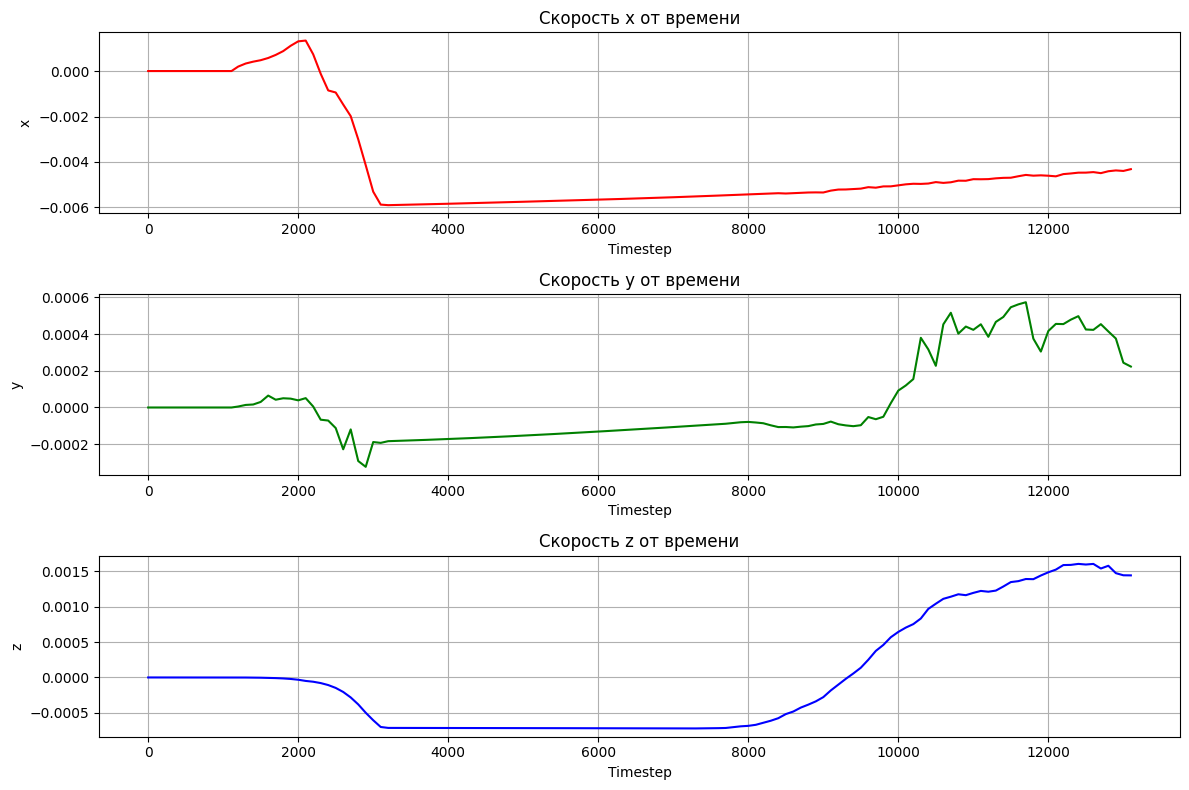

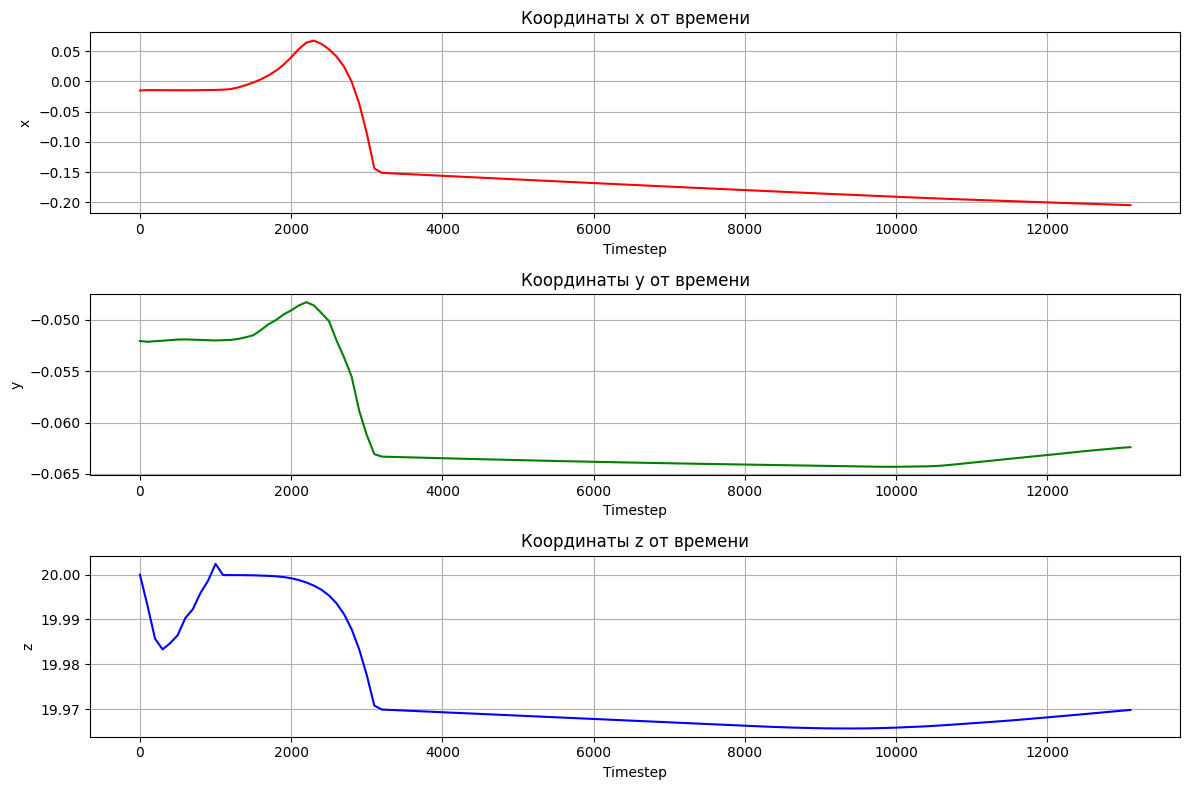

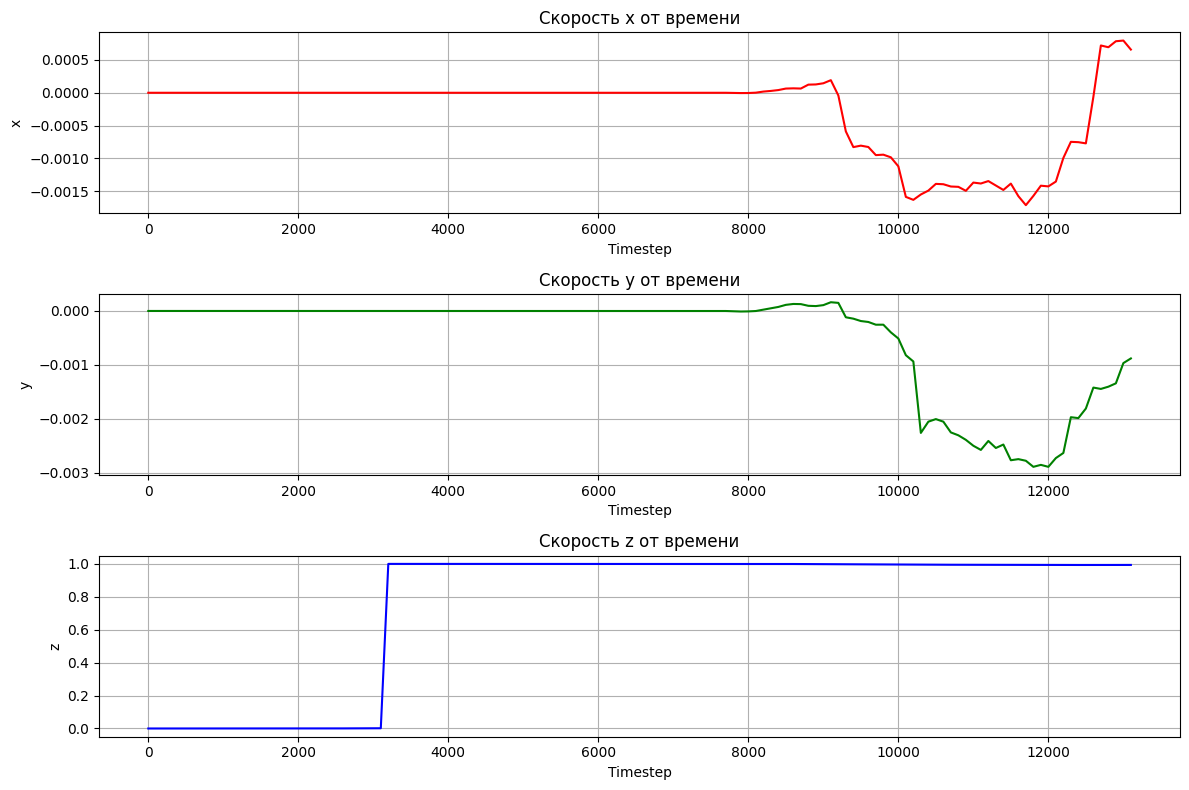

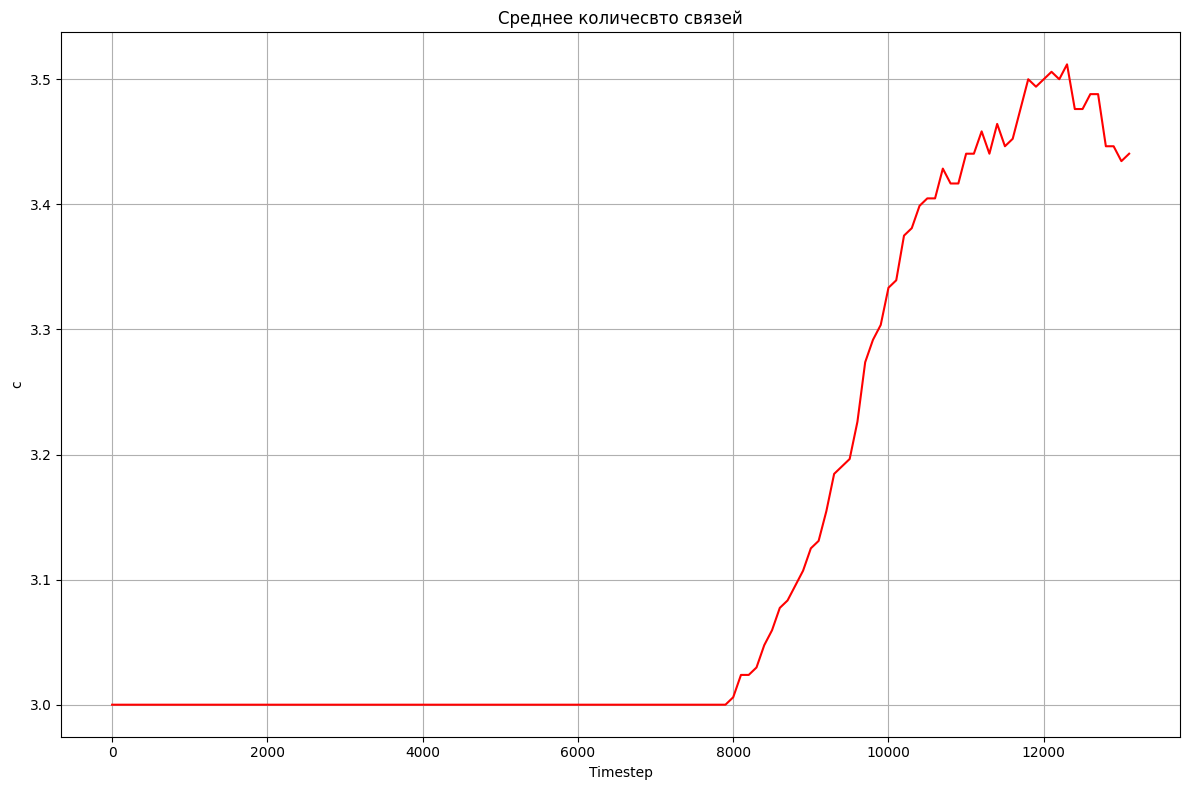

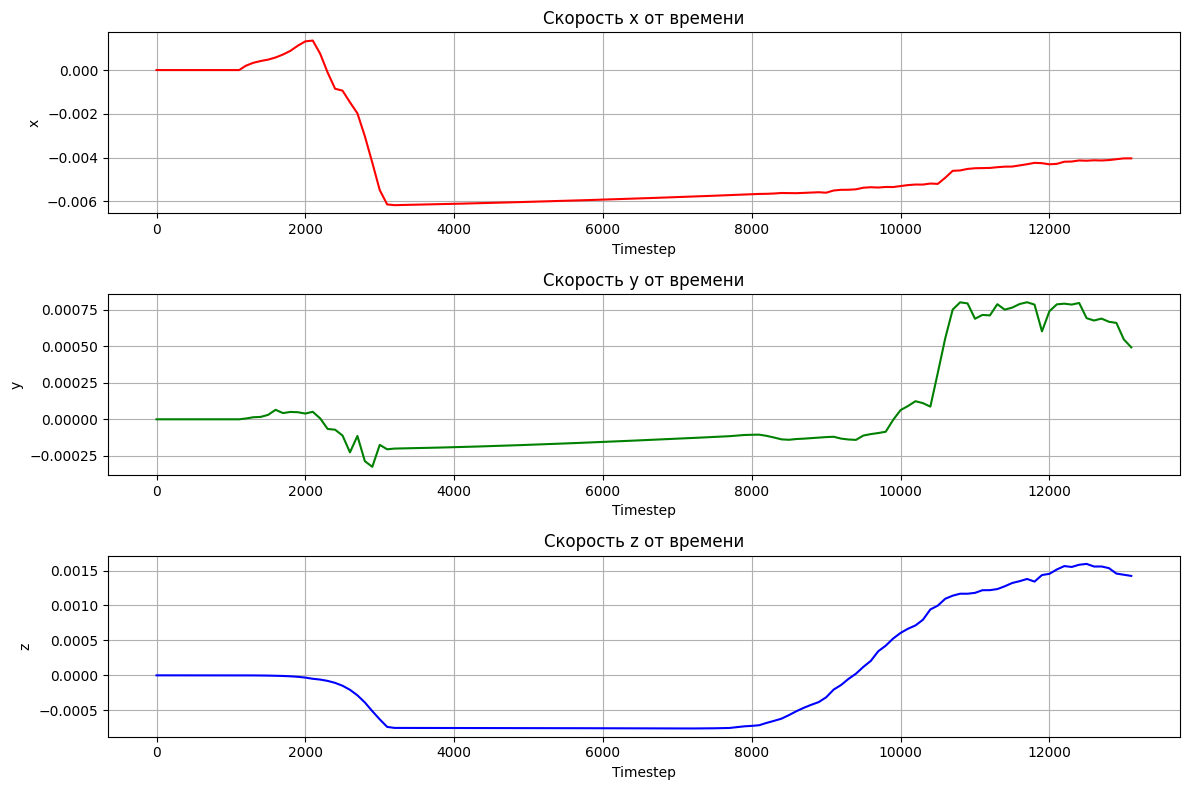

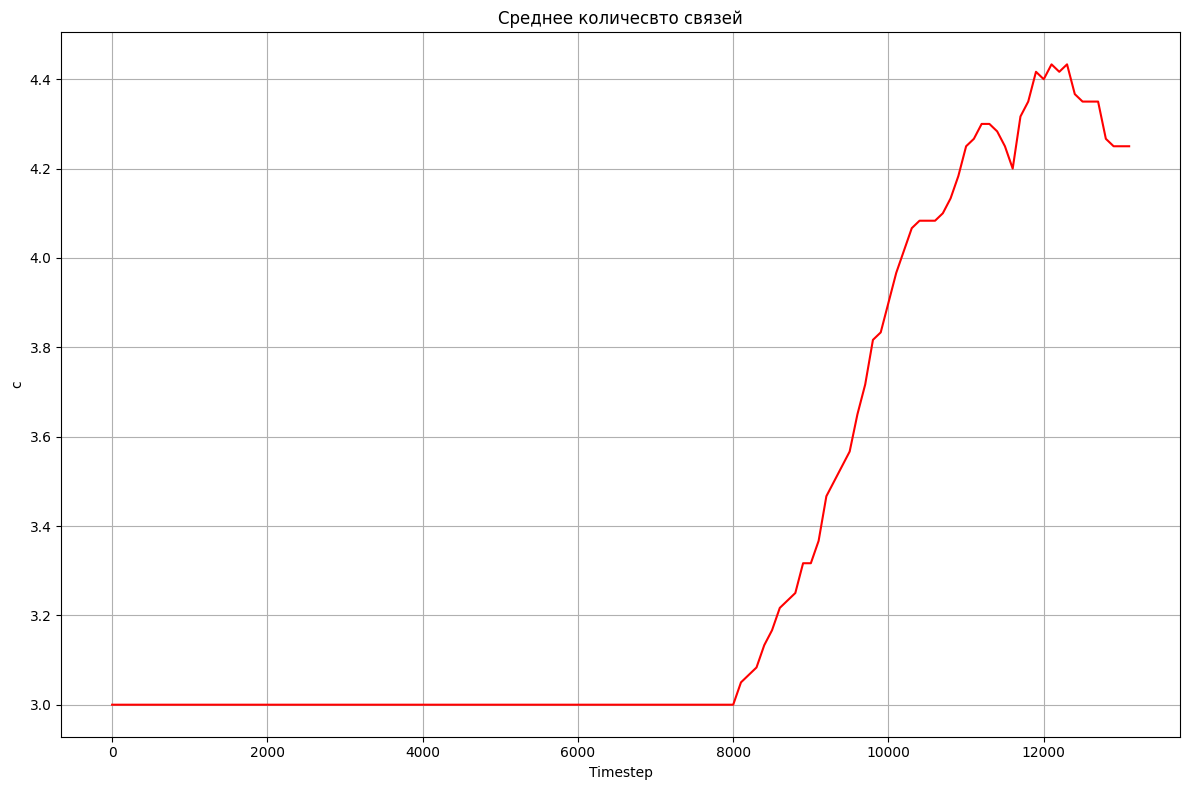

Фуллерен при Температуре 250, скорости 1.0 : сломан : False
Графен при Температуре 250, скорости 1.0 : сломан : False


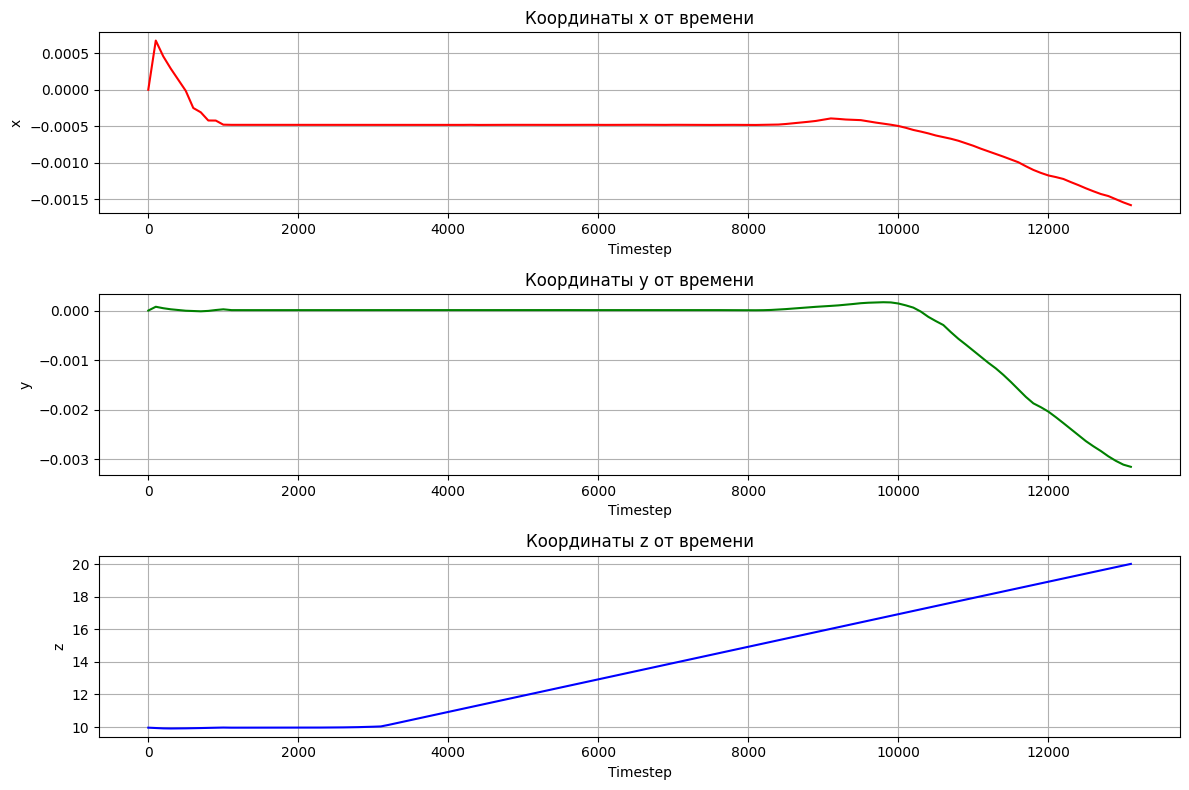

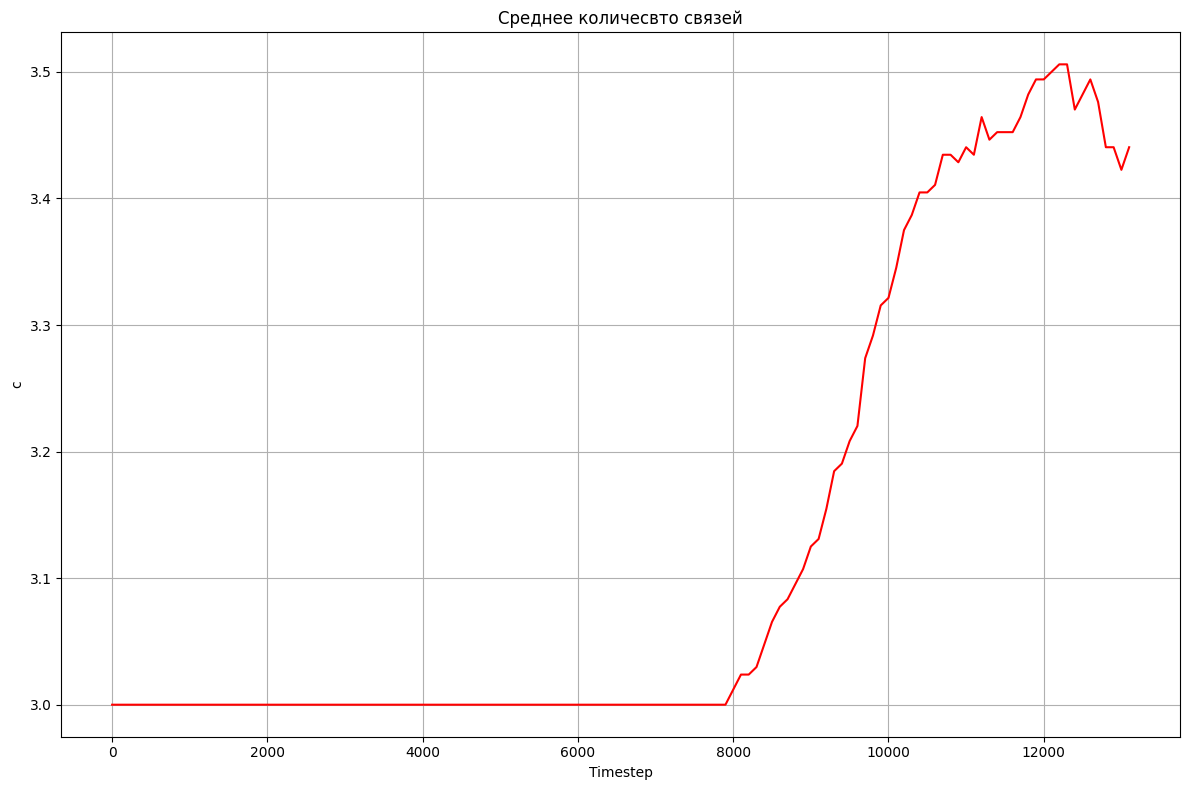

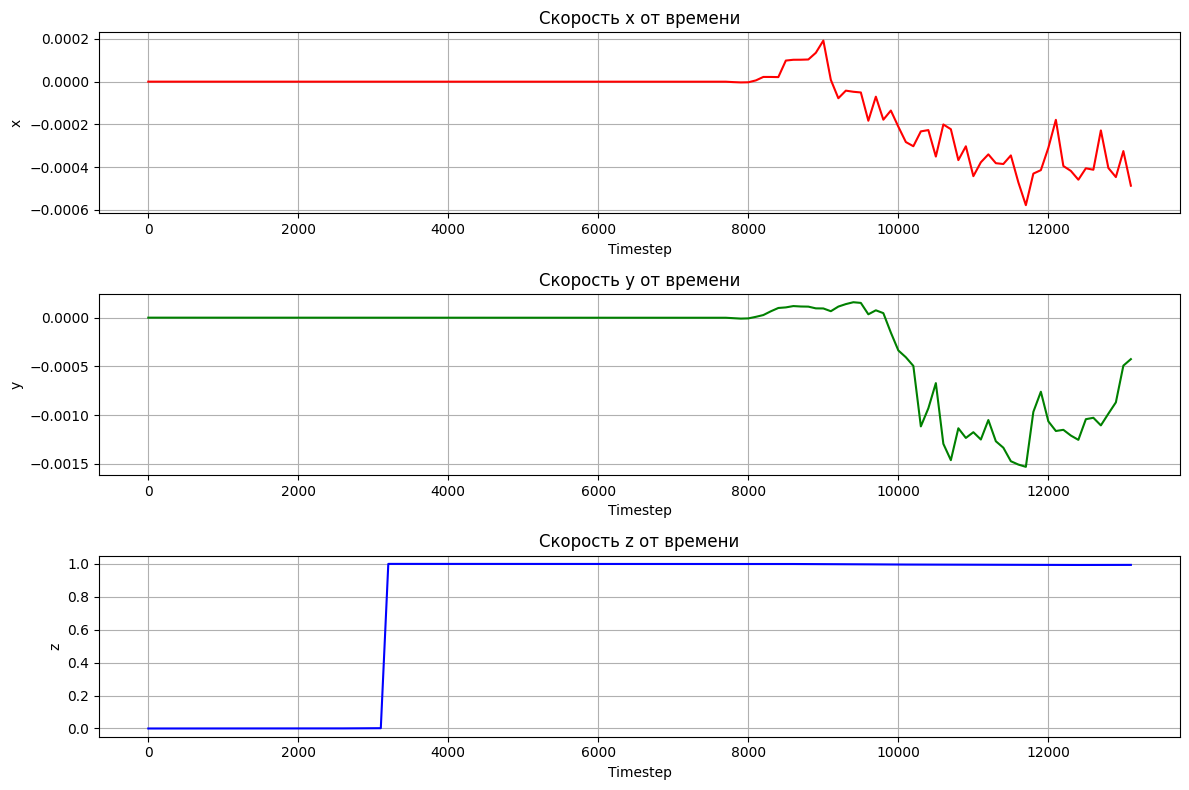

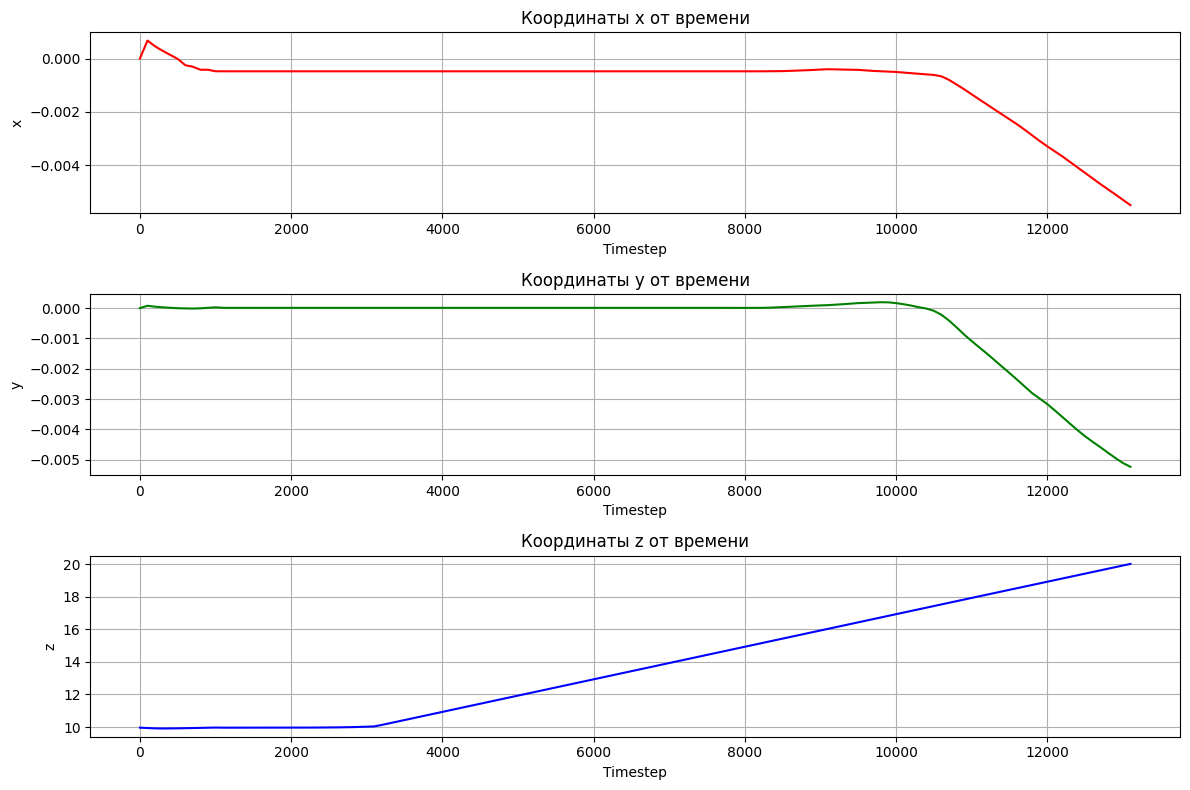

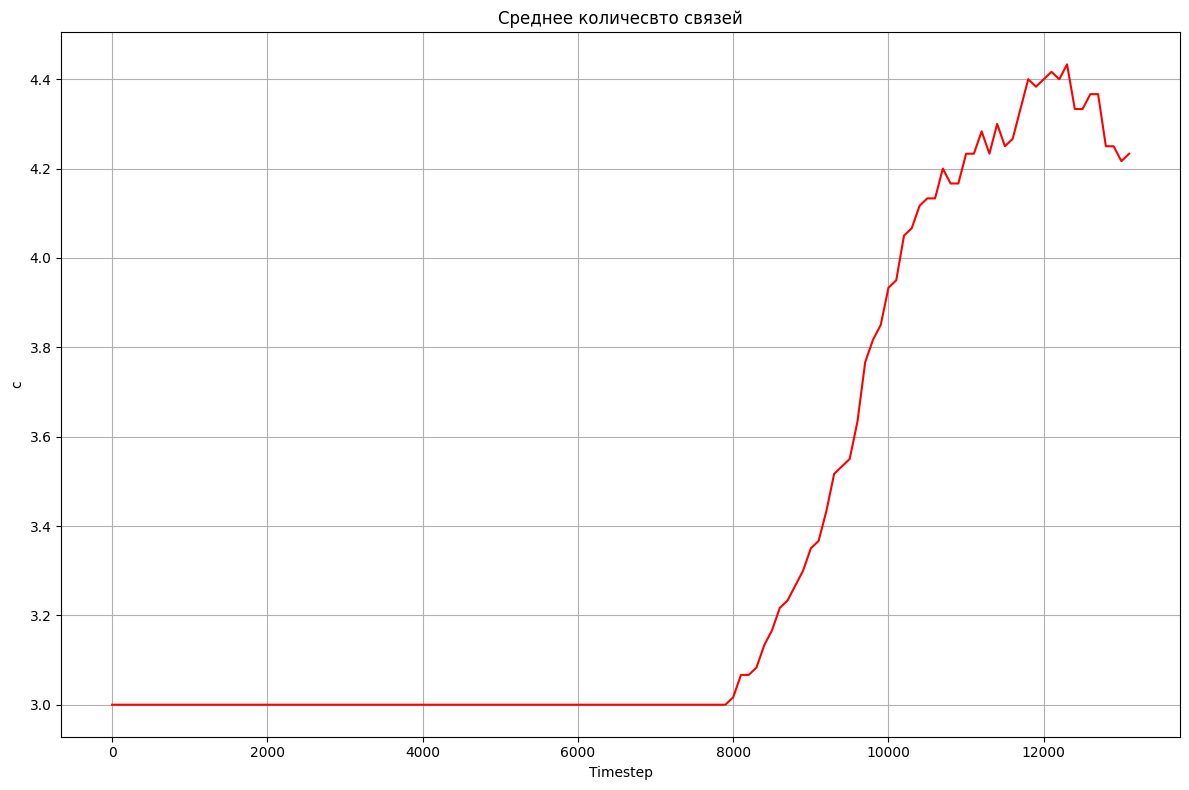

Фуллерен при Температуре 325, скорости 1.0 : сломан : False
Графен при Температуре 325, скорости 1.0 : сломан : False


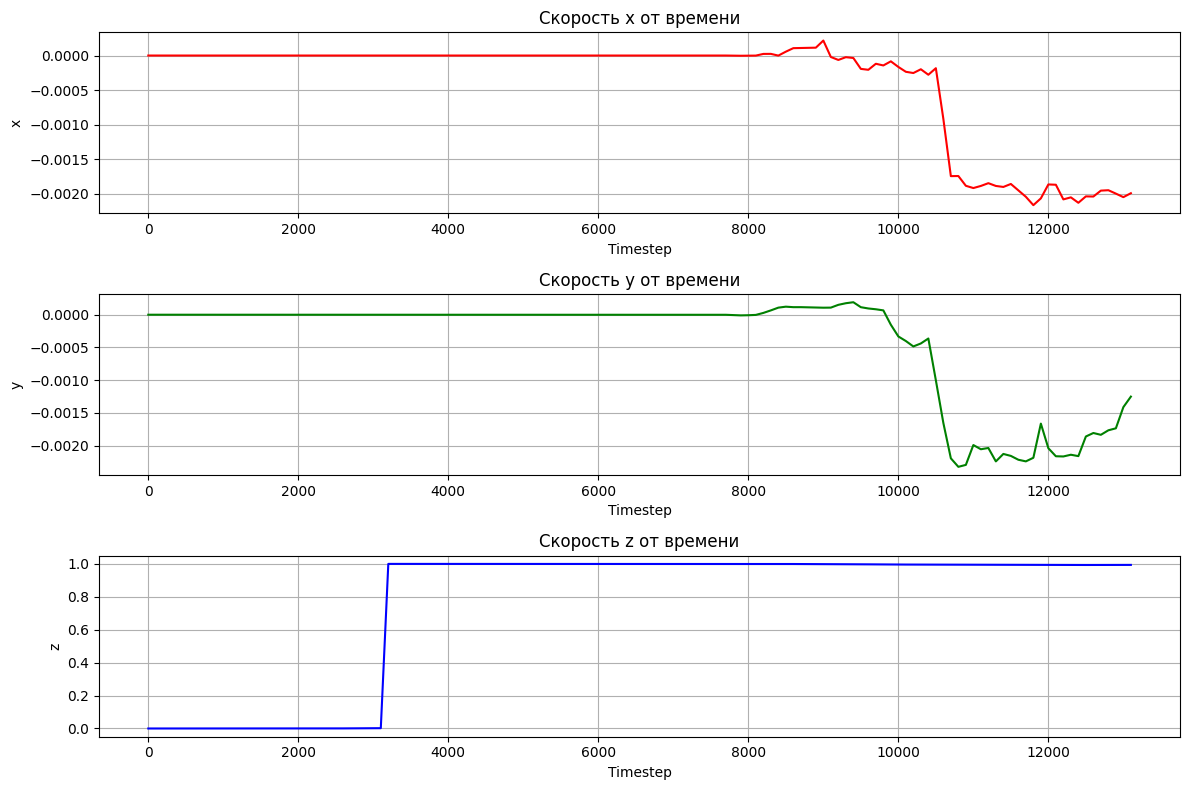

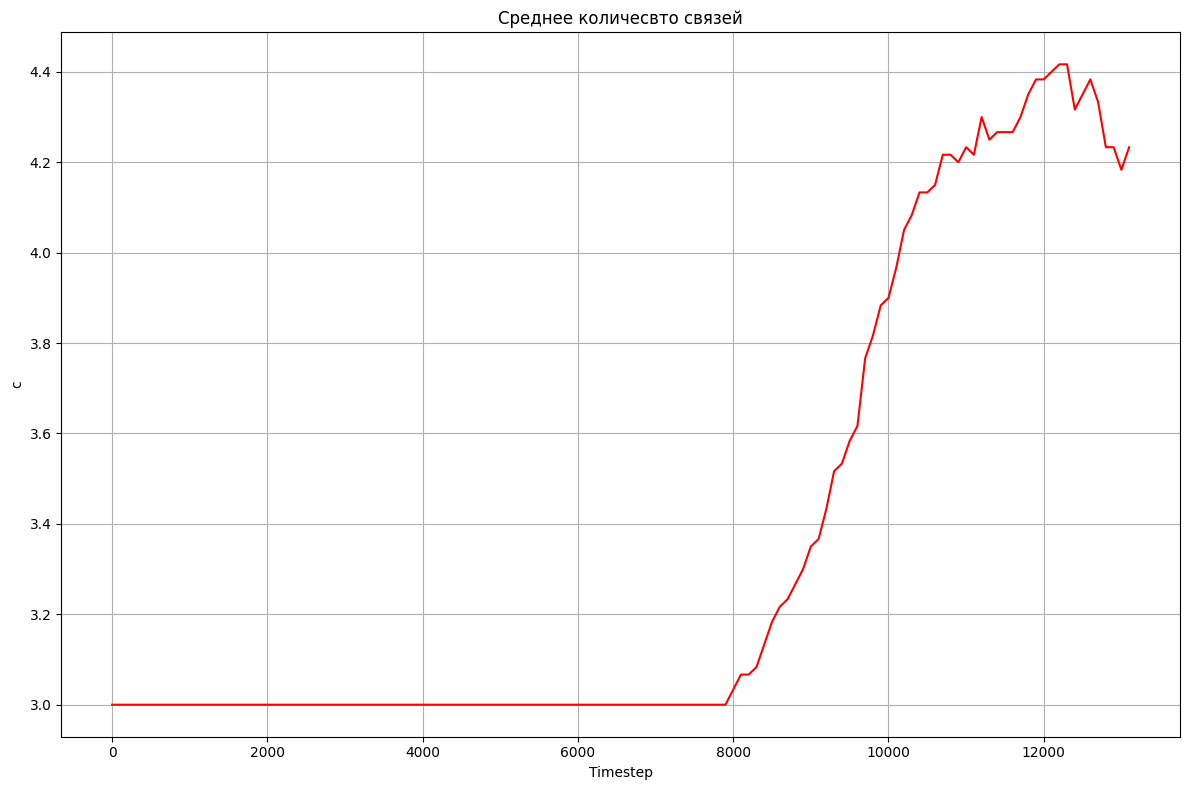

Фуллерен при Температуре 350, скорости 1.0 : сломан : False
Графен при Температуре 350, скорости 1.0 : сломан : False
LAMMPS simulation for velocity 1.0 started successfully!


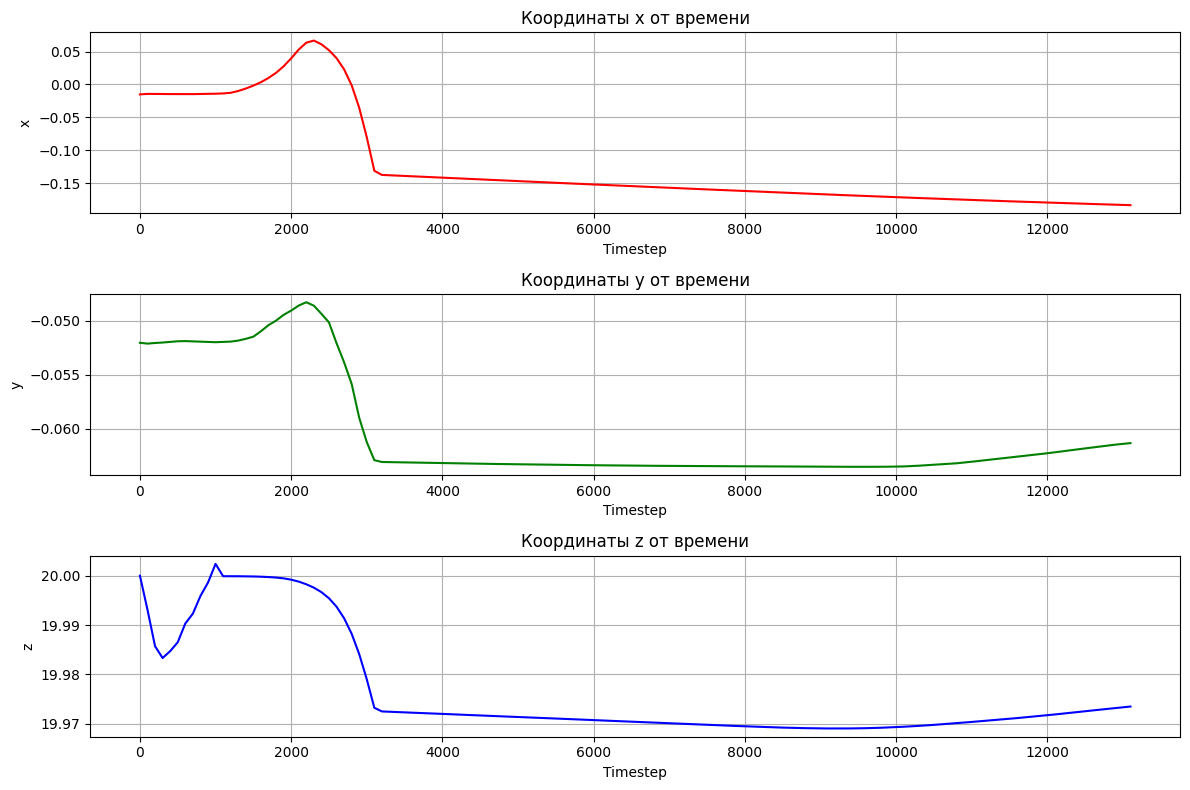

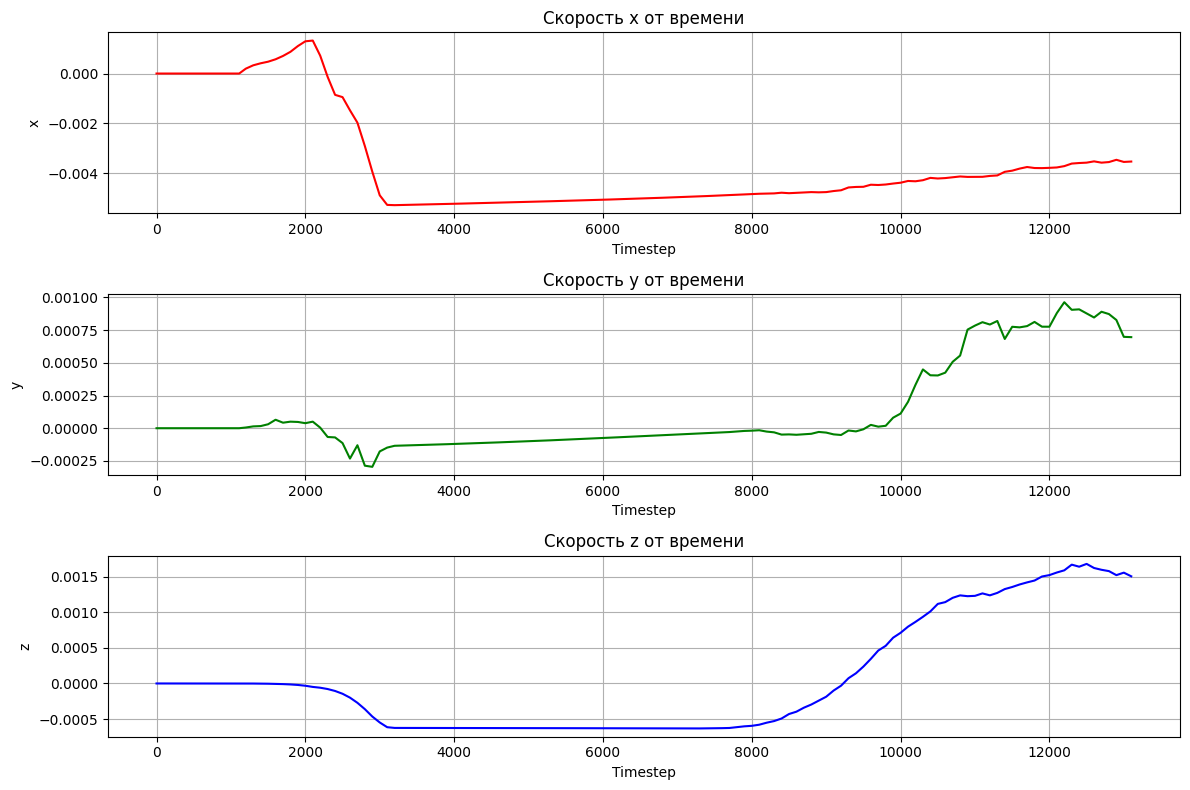

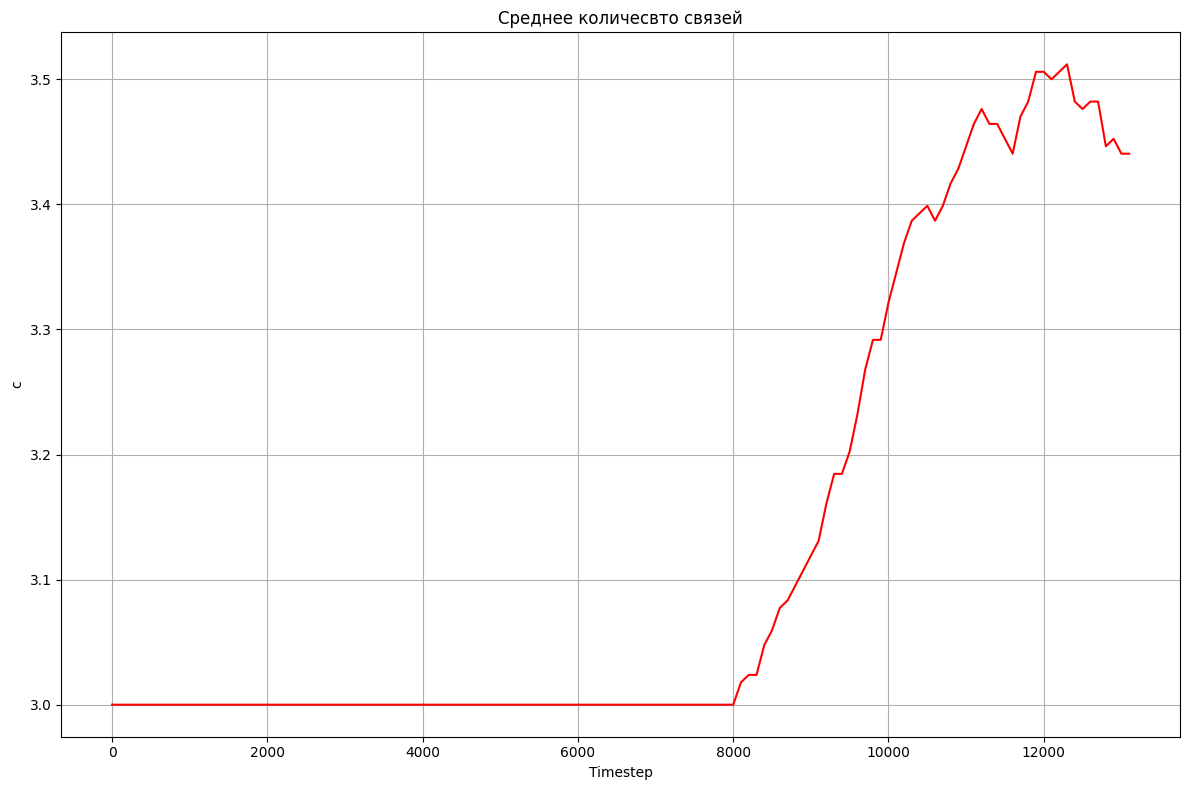

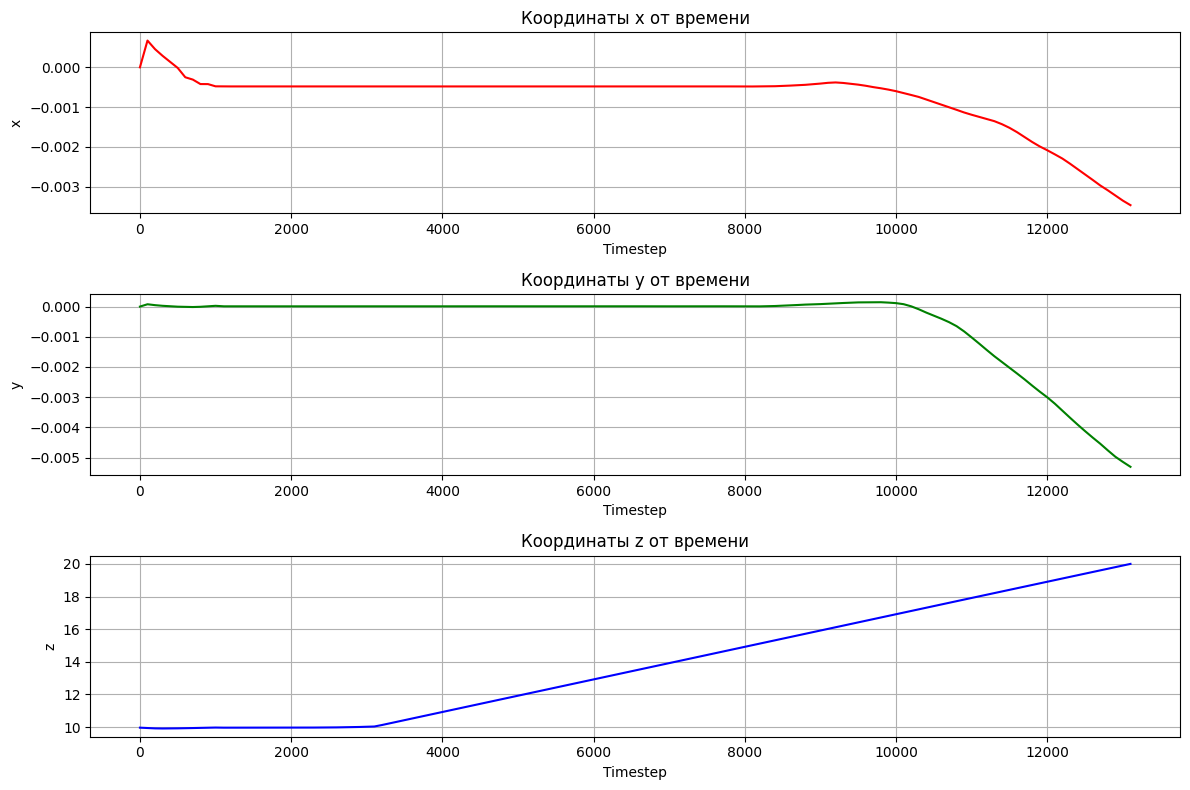

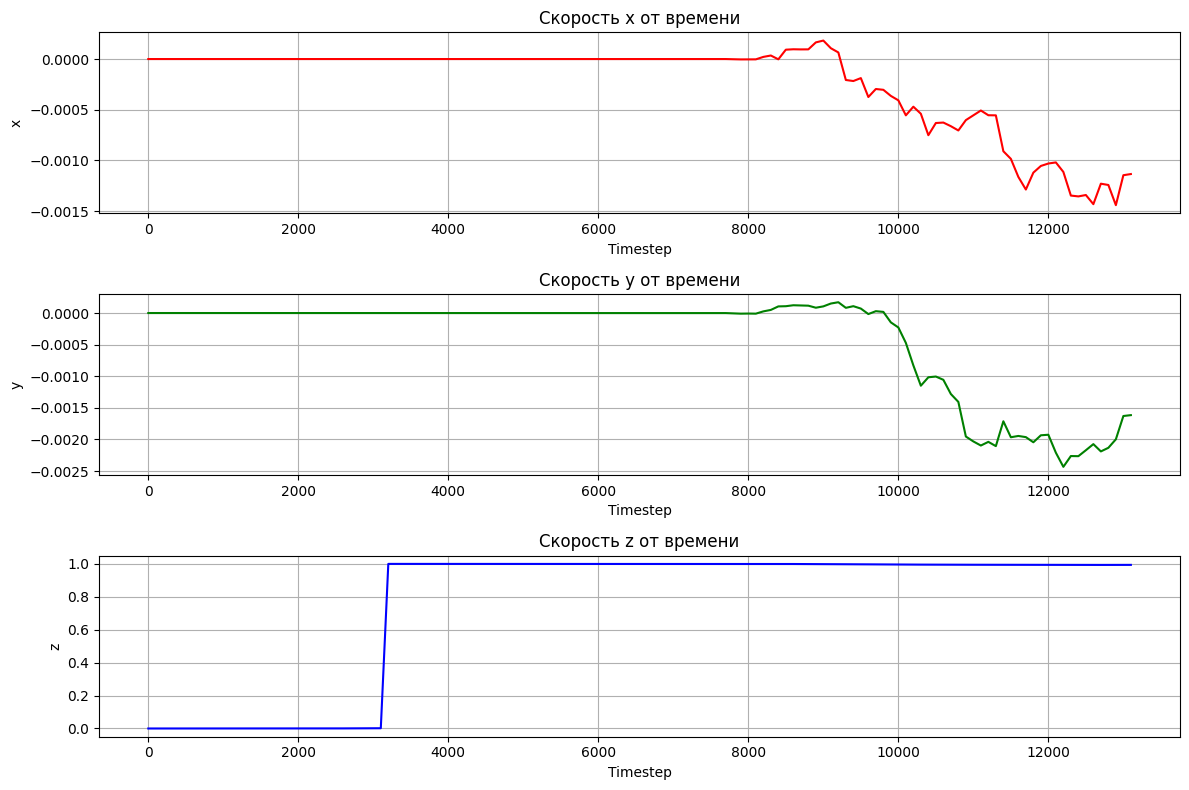

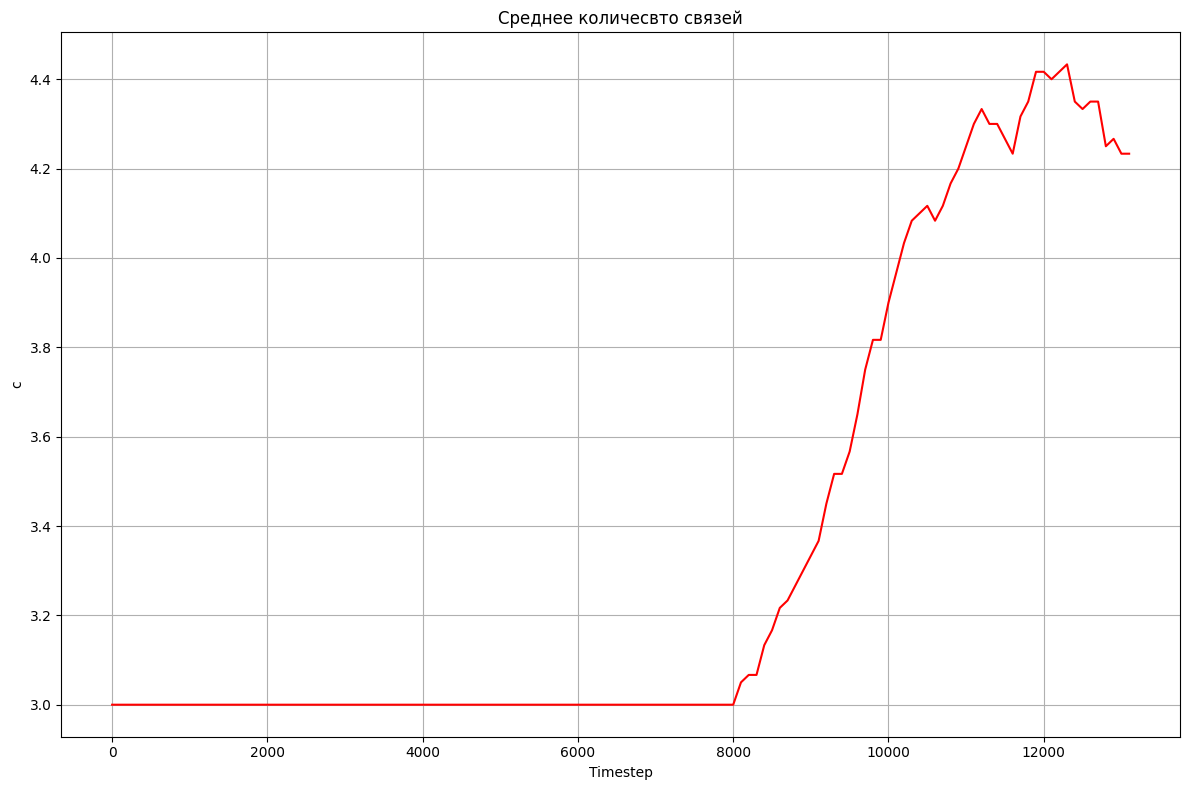

Фуллерен при Температуре 275, скорости 1.0 : сломан : False
Графен при Температуре 275, скорости 1.0 : сломан : False


In [10]:
import subprocess
import os
from LAMMPS_gen_in_file import * 
from LAMMPS_data_preprocess import * 
from LAMMPS_analysis import *
from concurrent.futures import ProcessPoolExecutor

test_num = 1

#velocities = [0.05, 0.1, 0.5, 1.]
temperatures = [250, 275, 300, 325, 350]

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(start_search, 0.01, 1.0, temperature) for temperature in temperatures]
    
    for future in futures:
        future.result()

In [3]:
import subprocess
import os
from LAMMPS_gen_in_file import * 
from LAMMPS_data_preprocess import * 
from LAMMPS_analysis import *
from concurrent.futures import ProcessPoolExecutor

velocities = [0.02, 0.05, 0.1, 0.5]
temperature = 300

test_num = 1

def run_lammps_simulation(velocity, temperature):
    dump_dir = "./runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    dump_dir_ = "runs/test_" + str(test_num) + "/vel_" + str(velocity) + "_temp_" + str(temperature)
    
    df_graphene = get_dataset(get_files(dump_dir_, el='gr'))
    df_c60 = get_dataset(get_files(dump_dir_, el='c60'))
    
    get_plots_coords_velocities(df_graphene, name=dump_dir_ + '/graphene')
    get_plots_coords_velocities(df_c60, name=dump_dir_ + '/c60')
    
    print(f'Фуллерен при Температуре {temperature}, скорости {velocity} : сломан : {is_broken(df_c60, alpha = 0.03)}')
    print(f'Графен при Температуре {temperature}, скорости {velocity} : сломан : {is_broken(df_graphene, alpha = 0.03)}')

    

# Используем ProcessPoolExecutor для параллельной обработки
with ProcessPoolExecutor() as executor:
    # Запускаем задачу для каждой скорости
    futures = [executor.submit(run_lammps_simulation, velocity, temperature) for velocity in velocities]
    
    # Ожидаем завершения всех задач
    for future in futures:
        future.result()  # Это заблокирует основной поток до завершения задачи

Фуллерен при Температуре 300, скорости 0.02 : сломан : False
Графен при Температуре 300, скорости 0.02 : сломан : False
Фуллерен при Температуре 300, скорости 0.5 : сломан : True
Графен при Температуре 300, скорости 0.5 : сломан : True
Фуллерен при Температуре 300, скорости 0.05 : сломан : False
Графен при Температуре 300, скорости 0.05 : сломан : False
Фуллерен при Температуре 300, скорости 0.1 : сломан : True
Графен при Температуре 300, скорости 0.1 : сломан : True


In [ ]:
import os
import subprocess
import sys
from LAMMPS_gen_in_file import * 
from LAMMPS_data_preprocess import * 
from LAMMPS_analysis import *
from concurrent.futures import ProcessPoolExecutor

# Устанавливаем номер теста
test_num = 1

# Настройка логирования
log_file = f"./runs/test_{test_num}/simulation.log"
os.makedirs(os.path.dirname(log_file), exist_ok=True)  # Создаем папку, если её нет

# Открываем файл и перенаправляем туда stdout и stderr
with open(log_file, "w") as log:
    sys.stdout = log
    sys.stderr = log

    # Логируем старт симуляции
    print("Starting LAMMPS simulation...")

    # Объявление ваших функций
    def run_lammps_simulation(velocity, temperature):
        dump_dir = f"./runs/test_{test_num}/vel_{velocity}_temp_{temperature}"
        dump_dir_ = f"runs/test_{test_num}/vel_{velocity}_temp_{temperature}"
        temp_ts = 0.01 * 0.02 / velocity

        os.makedirs(dump_dir, exist_ok=True)  # Создаем директории
        generate_in_file(
            velocity, temperature, dump_dir=dump_dir,
            output_file=f"{dump_dir_}/in.perforation",
            iterations=[1000, 1000, 0, 3000], ts=[0.1, 0.1, temp_ts]
        )

        os.system(f'cp C60.data {dump_dir_}/C60.data')

        prepare_data(
            graphene_size=[20, 20], input_c60_file=f"{dump_dir_}/C60.data",
            output_c60_centered=f"{dump_dir_}/centered_C60.data",
            output_graphene_centered=f"{dump_dir_}/centered_graphene.data",
            output_file=f"{dump_dir_}/combined.data",
            output_graphene=f"{dump_dir_}/graphene.data",
            z_graphene=20, z_c60=5
        )

        lammps_path = "/home/korotnev/Documents/LAMMPS/lammps-29Aug2024/src/lmp_serial"
        script_path = f"{dump_dir_}/in.perforation"

        try:
            result = subprocess.run([lammps_path, '-in', script_path], check=True,
                                    stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"LAMMPS simulation for velocity {velocity} started successfully!")
            print(result.stdout.decode())  # Печать stdout
            print(result.stderr.decode())  # Печать stderr
        except subprocess.CalledProcessError as e:
            print(f"Error occurred while running LAMMPS for velocity {velocity}: {e}")

        # Анализ результатов
        df_graphene = get_dataset(get_files(dump_dir_, el='gr'))
        df_c60 = get_dataset(get_files(dump_dir_, el='c60'))

        get_plots_coords_velocities(df_graphene, name=f"{dump_dir_}/graphene")
        get_plots_coords_velocities(df_c60, name=f"{dump_dir_}/c60")

        graphene_broken = is_broken(df_graphene, alpha=0.03)
        c60_broken = is_broken(df_c60, alpha=0.03)

        print(f"Graphene at T={temperature}, v={velocity}: Broken: {graphene_broken}")
        print(f"Fullerene at T={temperature}, v={velocity}: Broken: {c60_broken}")

        return is_broken(df_graphene, alpha=0.1)

    # Пример поиска скорости
    def find_velocity(v_min, v_max, temp, tol=0.1):
        print(f"Starting new velocity search with temp={temp}, v_min={v_min}, v_max={v_max}")
        if 2 * (v_max - v_min) / (v_max + v_min) < tol:
            print(f"Solution found: temp={temp}, velocity={(v_max + v_min) / 2}")
            return (v_max + v_min) / 2

        bool_ = run_lammps_simulation((v_max + v_min) / 2, temp)

        if bool_:
            return find_velocity(v_min, (v_max + v_min) / 2, temp, tol=tol)
        else:
            return find_velocity((v_max + v_min) / 2, v_max, temp, tol=tol)

    def start_search(v_min, v_max, temp, tol=0.1):
        b_min = run_lammps_simulation(v_min, temp)
        b_max = run_lammps_simulation(v_max, temp)

        if (b_min and b_max) or (not b_min and not b_max):
            print("Cannot find solution.")
            return 0
        return find_velocity(v_min, v_max, temp, tol=tol)

    # Параметры запуска
    temperatures = [250, 275, 300, 325]

    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(start_search, 0.01, 1.0, temperature) for temperature in temperatures]

        for future in futures:
            future.result()

    # Заканчиваем лог
    print("Simulation finished.")